In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, AutoEncoderDataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
from tqdm import tqdm_notebook
import seaborn as sns
from helpers.normalization import normalize, denormalize, renormalize
import control
import scipy

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [4]:
model_path = '~/run_results_11_19/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_25Nov19-15-05_Scenario-10.h5'
model = keras.models.load_model(os.path.expanduser(model_path), compile=False)
print('loaded model: ' + model_path.split('/')[-1])
file_path = model_path[:-3] + '_params.pkl'
with open(os.path.expanduser(file_path), 'rb') as f:
     scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))
scenario['dt'] = 0.05

loaded model: model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_25Nov19-15-05_Scenario-10.h5
loaded dict: model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_25Nov19-15-05_Scenario-10_params.pkl
with parameters: dict_keys(['process_data', 'x_weight', 'u_weight', 'discount_factor', 'window_length', 'actuator_names', 'profile_names', 'scalar_names', 'profile_downsample', 'state_encoder_type', 'state_decoder_type', 'control_encoder_type', 'control_decoder_type', 'state_encoder_kwargs', 'state_decoder_kwargs', 'control_encoder_kwargs', 'control_decoder_kwargs', 'state_latent_dim', 'control_latent_dim', 'batch_size', 'epochs', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'sh

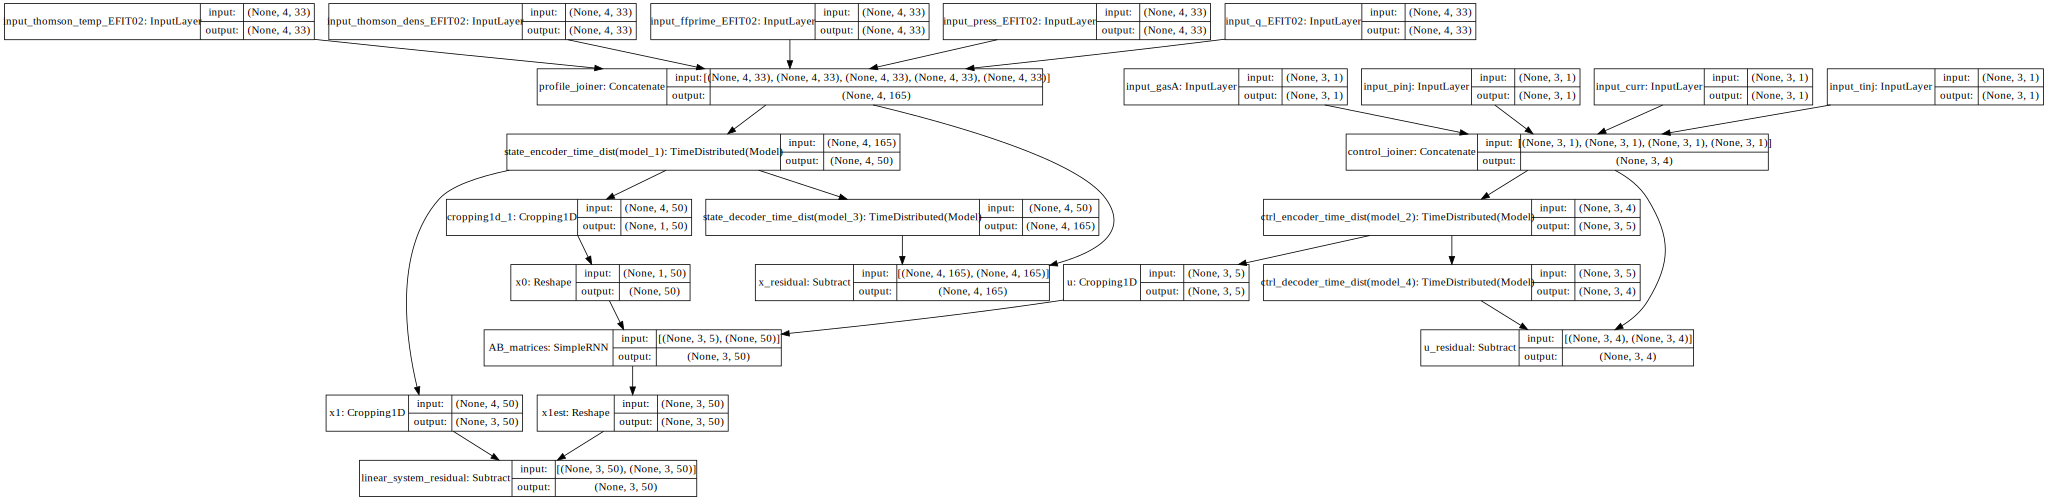

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True,show_layer_names=True,rankdir='TB').create(prog='dot', format='svg'))

In [6]:
def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = Model(model.get_layer('state_decoder_time_dist').layer.layers[0].input,
                          model.get_layer('state_decoder_time_dist').layer.layers[-2].get_output_at(1),
                         name='state_decoder')    
    control_decoder = Model(model.get_layer('ctrl_decoder_time_dist').layer.layers[0].input,
                            model.get_layer('ctrl_decoder_time_dist').layer.layers[-2].get_output_at(1),
                           name='control_decoder')
 
    return state_encoder, state_decoder, control_encoder, control_decoder

In [7]:
A,B = get_AB(model)
state_encoder, state_decoder, control_encoder, control_decoder = get_submodels(model)

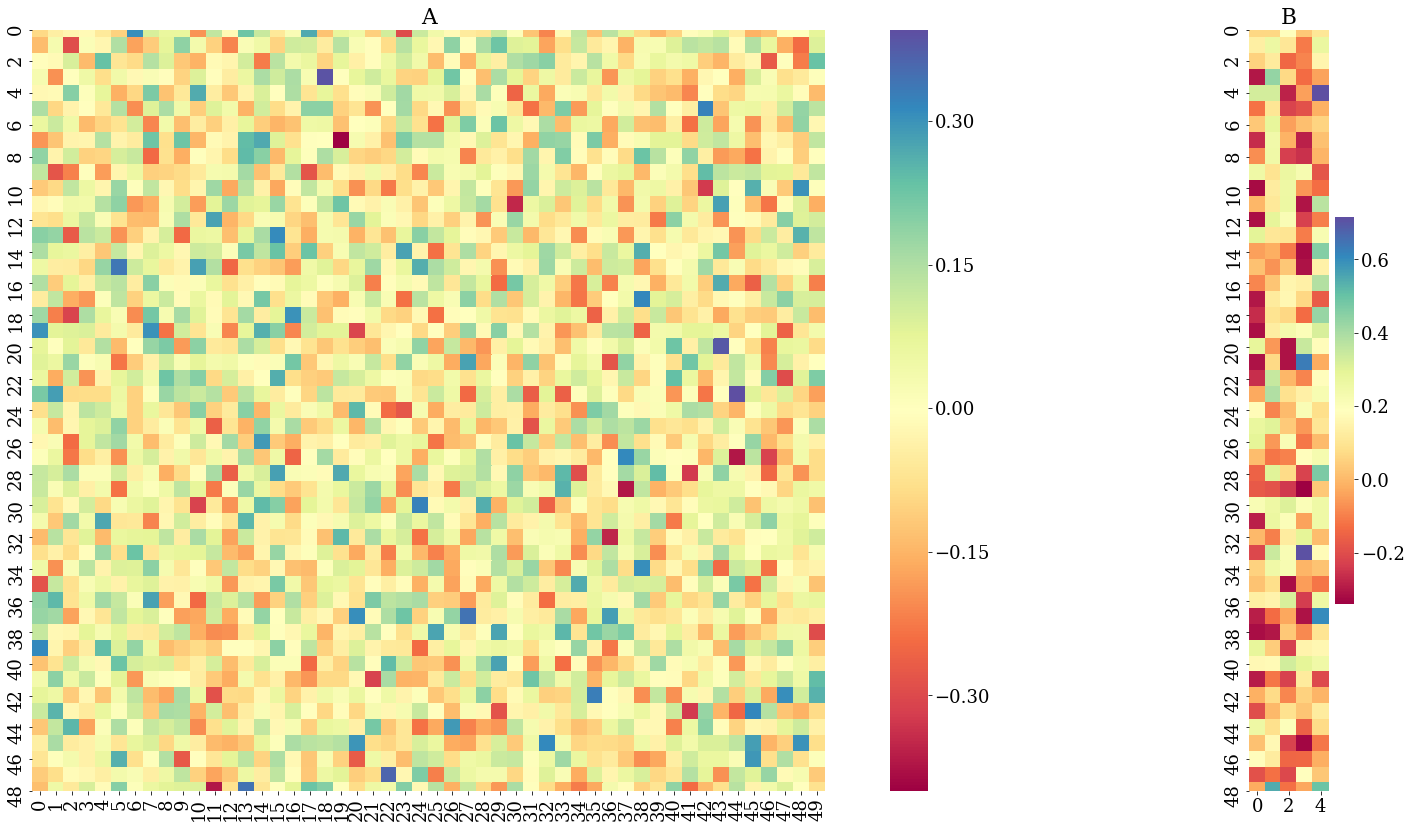

In [8]:
def plot_autoencoder_AB(model,scenario, filename=None, **kwargs):
    
    font={'family': 'DejaVu Serif',
      'size': 18}
    plt.rc('font', **font)
    matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)
    
    A,B = get_AB(model)
    f, axes = plt.subplots(1, 2, figsize=(28, 14),
                           gridspec_kw={'width_ratios': [scenario['state_latent_dim'], 
                                                         scenario['control_latent_dim']]})
    sns.heatmap(A, 
                cmap=kwargs.get('cmap','Spectral'),
                annot=kwargs.get('annot',False), 
                square=kwargs.get('square',True), 
                robust=kwargs.get('robust',False), 
                ax=axes[0]).set_title('A')
    sns.heatmap(B,
                cmap=kwargs.get('cmap','Spectral'), 
                annot=kwargs.get('annot',False), 
                square=kwargs.get('square',True), 
                robust=kwargs.get('robust',False), 
                ax=axes[1]).set_title('B')

    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f

f = plot_autoencoder_AB(model,scenario)

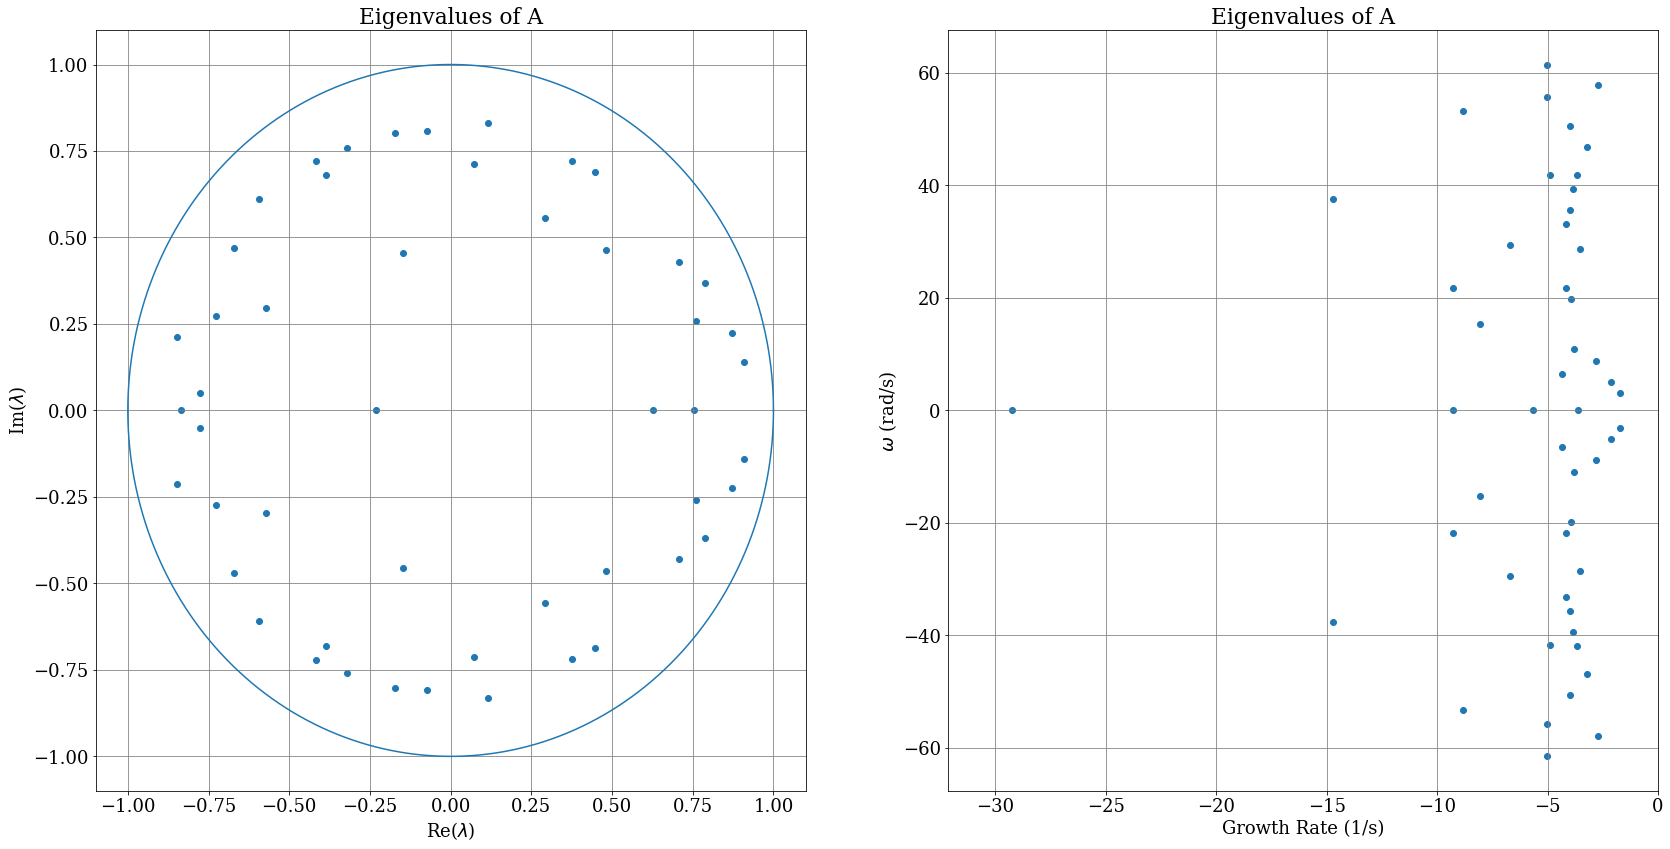

In [9]:
## Plot spectrum of A
def plot_autoencoder_spectrum(model,scenario, filename=None, **kwargs):

    font={'family': 'DejaVu Serif',
          'size': 18}
    plt.rc('font', **font)
    matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)
    
    dt = scenario['dt']
    A,B = get_AB(model)
    eigvals, eigvecs = np.linalg.eig(A)
    logeigvals = np.log(eigvals)
    for i, elem in enumerate(logeigvals):
        if abs(np.imag(elem)-np.pi)<np.finfo(np.float32).resolution:
            logeigvals[i] = np.real(elem) + 0j
    logeigvals = logeigvals/dt

    f, axes = plt.subplots(1, 2, figsize=(28, 14))
    axes[0].scatter(np.real(eigvals),np.imag(eigvals))
    t = np.linspace(0,2*np.pi,1000)
    axes[0].plot(np.cos(t),np.sin(t))

    axes[0].set_title('Eigenvalues of A')
    axes[0].grid(color='gray')
    axes[0].set_xlabel('Re($\lambda$)')
    axes[0].set_ylabel('Im($\lambda$)')


    axes[1].scatter(np.real(logeigvals),np.imag(logeigvals))
    axes[1].set_title('Eigenvalues of A')
    axes[1].grid(color='gray')
    axes[1].set_xlabel('Growth Rate (1/s)')
    axes[1].set_ylabel('$\omega$ (rad/s)')
    axes[1].set_xlim((1.1*np.min(np.real(logeigvals)),np.maximum(1.1*np.max(np.real(logeigvals)),0)))
    
    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f
        
f = plot_autoencoder_spectrum(model, scenario)


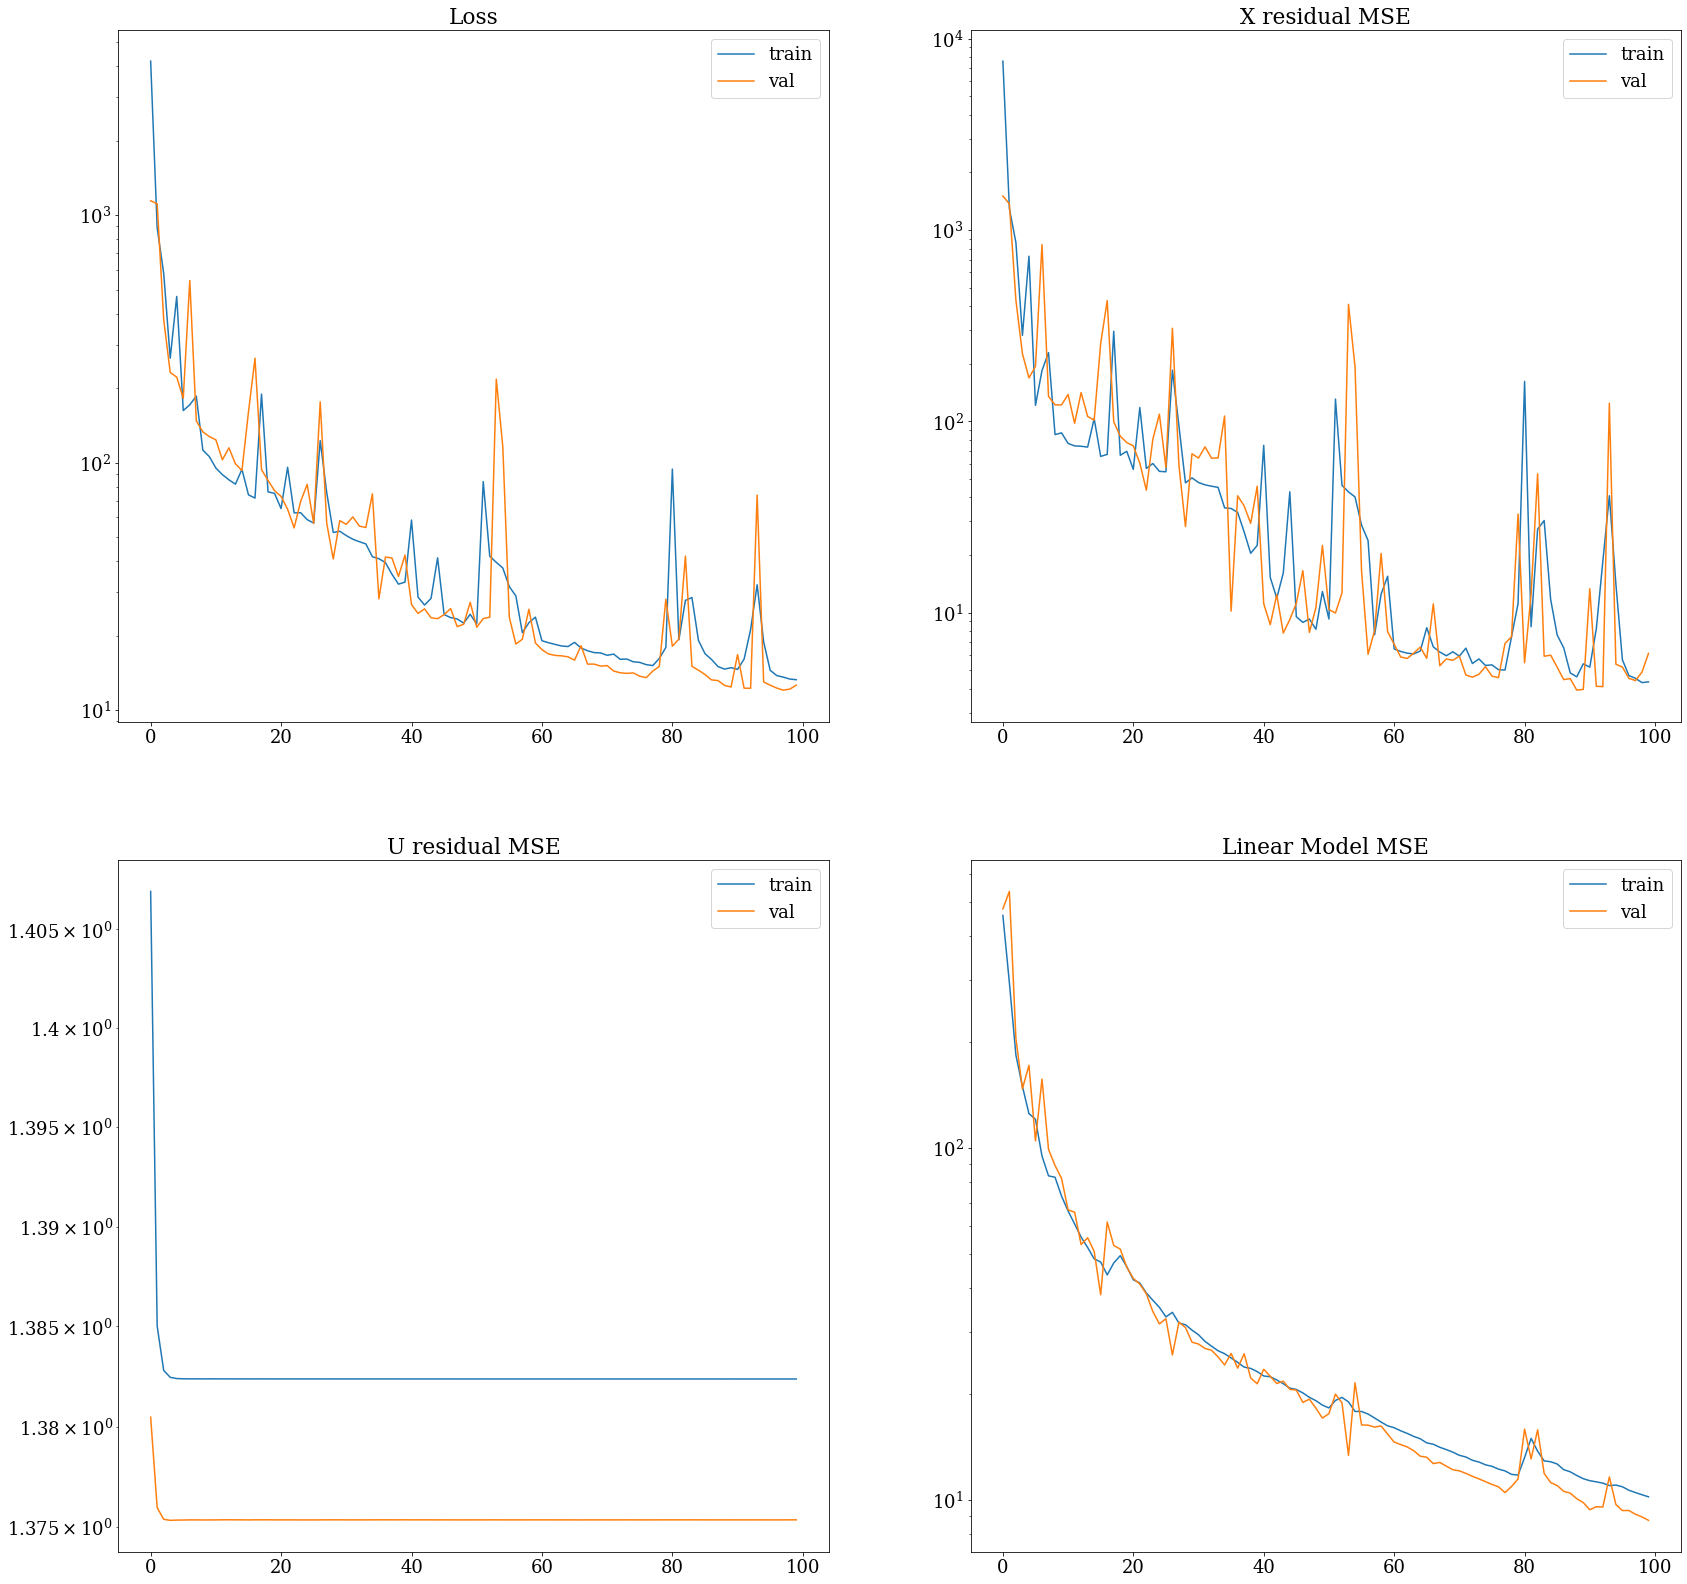

In [10]:
def plot_autoencoder_training(model,scenario,filename=None,**kwargs):

    font={'family': 'DejaVu Serif',
      'size': 18}
    plt.rc('font', **font)
    matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)
    
    f, axes = plt.subplots(2, 2, figsize=(28, 28))
    axes[0,0].semilogy(scenario['history']['loss'],label='train')
    axes[0,0].semilogy(scenario['history']['val_loss'],label='val')
    axes[0,0].set_title('Loss')
    axes[0,0].legend()

    axes[0,1].semilogy(scenario['history']['x_residual_mean_squared_error'],label='train')
    axes[0,1].semilogy(scenario['history']['val_x_residual_mean_squared_error'],label='val')
    axes[0,1].set_title('X residual MSE')
    axes[0,1].legend()

    axes[1,0].semilogy(scenario['history']['u_residual_mean_squared_error'],label='train')
    axes[1,0].semilogy(scenario['history']['val_u_residual_mean_squared_error'],label='val')
    axes[1,0].set_title('U residual MSE')
    axes[1,0].legend()

    axes[1,1].semilogy(scenario['history']['linear_system_residual_mean_squared_error'],label='train')
    axes[1,1].semilogy(scenario['history']['val_linear_system_residual_mean_squared_error'],label='val')
    axes[1,1].set_title('Linear Model MSE')
    axes[1,1].legend()
    
    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f
        
f = plot_autoencoder_training(model,scenario)


In [12]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

def write_results(scenario,model):
    
    if 'image_path' not in scenario.keys():
        scenario['image_path'] = 'https://jabbate7.github.io/plasma-profile-predictor/results/' + scenario['runname']
    
    base_sheet_path = "https://docs.google.com/spreadsheets/d/1GbU2FaC_Kz3QafGi5ch97mHbziqGz9hkH5wFjiWpIRc/edit#gid=0"
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
    client = gspread.authorize(creds)
    sheet = client.open_by_url(base_sheet_path).sheet1
    
    write_scenario_to_sheets(scenario,sheet)
    rowid = sheet.find(scenario['runname']).row
    scenario['sheet_path'] = base_sheet_path + "&range={}:{}".format(rowid,rowid)
    
    results_dir =os.path.expanduser('~/plasma-profile-predictor/results/'+scenario['runname'])  
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    os.chdir(results_dir)
    f = open('index.html','w+')
    f.write('<html><head></head><body>')
    html = scenario_to_html(scenario)
    f.write(html + '<p>\n')
    _, html = plot_autoencoder_training(model,scenario, filename='training.png')
    f.write(html + '<p>\n')
    _, html = plot_AB(model,scenario, filename='AB.png')
    f.write(html + '<p>\n')
    _, html = plot_spectrum(model,scenario, filename='spectrum.png')
    f.write(html + '<p>\n')
    f.write('</body></html>')
    f.close()
    
    
def write_scenario_to_sheets(scenario,sheet):
    sheet_keys = sheet.row_values(1)
    row = [None]*len(sheet_keys)
    for i,key in enumerate(sheet_keys):
        if key in scenario.keys():
            row[i] = str(scenario[key])
        elif key in scenario.get('history',{}):
            row[i] = str(scenario['history'][key][-1])
    sheet.append_row(row)

def scenario_to_html(scenario):
    foo = {k:v for k,v in scenario.items() if k not in ['history','normalization_dict','history_params']}
    def printitems(dictObj, indent=0):
        p=[]
        p.append('<ul>\n')
        for k,v in dictObj.items():
            if isinstance(v, dict):
                p.append('<li><b>'+ str(k)+ '</b>: ')
                p.append(printitems(v))
                p.append('</li>\n')
            elif k in ['image_path','sheet_path']:
                p.append("<a href=\"" + str(v) + "\">" + str(k) + "</a>\n")          
            else:
                p.append('<li><b>'+ str(k)+ '</b>: '+ str(v)+ '</li>\n')
        p.append('</ul>\n')
        return ''.join(p)
    return printitems(foo)

In [17]:
base_sheet_path = "https://docs.google.com/spreadsheets/d/1GbU2FaC_Kz3QafGi5ch97mHbziqGz9hkH5wFjiWpIRc/edit#gid=0"
scope = ['https://spreadsheets.google.com/feeds',
     'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
client = gspread.authorize(creds)
sheet = client.open_by_url(base_sheet_path).sheet1
col = sheet.find('runname').col
runs = sheet.col_values(col)
runs

['runname',
 'model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_25Nov19-15-05_Scenario-10',
 'model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_29Nov19-23-10',
 'model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_29Nov19-23-16',
 'model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_29Nov19-23-19']

In [12]:
dt = .05
# Ac = logm(Ad)/dt
Ac = scipy.linalg.logm(A)/dt
# Bc = inv(Ad-I)*Ac*Bd
Bc = np.matmul(np.linalg.inv(A-np.eye(scenario['state_latent_dim'])),np.matmul(Ac,B))
C = np.eye(scenario['state_latent_dim'])
D = np.zeros((scenario['state_latent_dim'],scenario['control_latent_dim']))

Wcc = scipy.linalg.solve_continuous_lyapunov(Ac,-Bc.dot(Bc.T))
Wdc = scipy.linalg.solve_discrete_lyapunov(A,B.dot(B.T))

Wco = scipy.linalg.solve_continuous_lyapunov(Ac.T,-C.dot(C.T)).T
Wdo = scipy.linalg.solve_discrete_lyapunov(A.T,C.dot(C.T)).T






logm result may be inaccurate, approximate err = 2.6861127030165117e-06


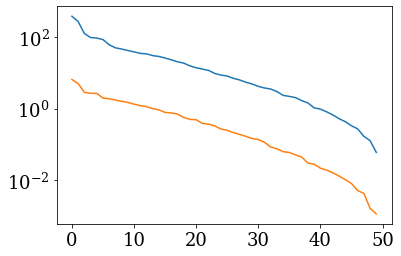

In [13]:
plt.semilogy(np.linalg.svd(Wcc,compute_uv=False))
plt.semilogy(np.linalg.svd(Wdc,compute_uv=False))


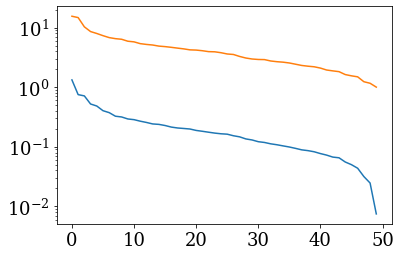

In [14]:
plt.semilogy(np.linalg.svd(Wco,compute_uv=False))
plt.semilogy(np.linalg.svd(Wdo,compute_uv=False))

In [50]:
os.getcwd()

'/home/wconlin/plasma-profile-predictor'

In [49]:
os.chdir('..')

In [21]:
datapath = '/scratch/gpfs/jabbate/mixed_data/final_data_batch_80.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
data = {163303: rawdata[163303]}
traindata, valdata, normalization_dict = process_data(data,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookback'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1,
                                                      0,
                                                      scenario['nshots'],
                                                      1,
                                                      scenario['flattop_only'],
                                                      randomize=False)
traindata = denormalize(traindata, normalization_dict)
traindata = renormalize(traindata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(traindata,
                                               scenario['batch_size'],
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])
times = [2000, 2480, 3080, 4040, 4820, 5840]
shots = [163303]*len(times)


Signals: curr, ffprime_EFIT02, gasA, pinj, press_EFIT02, q_EFIT02, thomson_dens_EFIT02, thomson_temp_EFIT02, tinj
Number of useable shots:  1
Number of shots used:  1
Total number of timesteps:  319


Gathering: 100%|##########| 1/1 [00:00<00:00,  2.77it/s]

Shots with Complete NaN: 



Stacking: 100%|##########| 18/18 [00:00<00:00, 5018.44it/s]

84 samples total
Removing ECH
Removing weird gas
84 samples remaining after pruning



Normalizing: 100%|##########| 18/18 [00:00<00:00, 2454.16it/s]

Total number of samples:  84
Number of training samples:  84
Number of validation samples:  0


In [9]:
np.unique(traindata['shotnum'])

array([175642., 175643., 175644., 175645., 175649., 175650., 175651.,
       175652., 175669., 175671., 175672., 175673., 175674., 175676.,
       175679., 175681., 175684., 175688., 175691., 175692., 175694.,
       175695., 175696., 175697., 175698., 175700., 175701., 175702.])

In [10]:
A,B = get_AB(model)
state_encoder, state_decoder, control_encoder, control_decoder = get_submodels(model)

In [99]:
inputs['input_thomson_temp_EFIT02'].shape

(1, 4, 33)

In [18]:
state_inputs = {}
for sig in scenario['profile_names']+scenario['scalar_names']:
    state_inputs['input_'+sig] = inputs['input_'+sig]
control_inputs = {}
for sig in scenario['actuator_names']:
    control_inputs['input_'+sig] = inputs['input_'+sig]

In [40]:
control_inputs

{'input_pinj': array([[-0.19917908, -0.19452305,  0.21338817,  0.42051559]]),
 'input_curr': array([[1.06022326, 1.13724532, 1.2373943 , 1.32202349]]),
 'input_tinj': array([[-0.04326918, -0.04142794,  0.19740423,  0.31876831]]),
 'input_gasA': array([[-0.05679931, -0.05297   , -0.05356277, -0.07266187]])}

In [101]:
control_inputs['input_pinj'].shape

(1, 4)

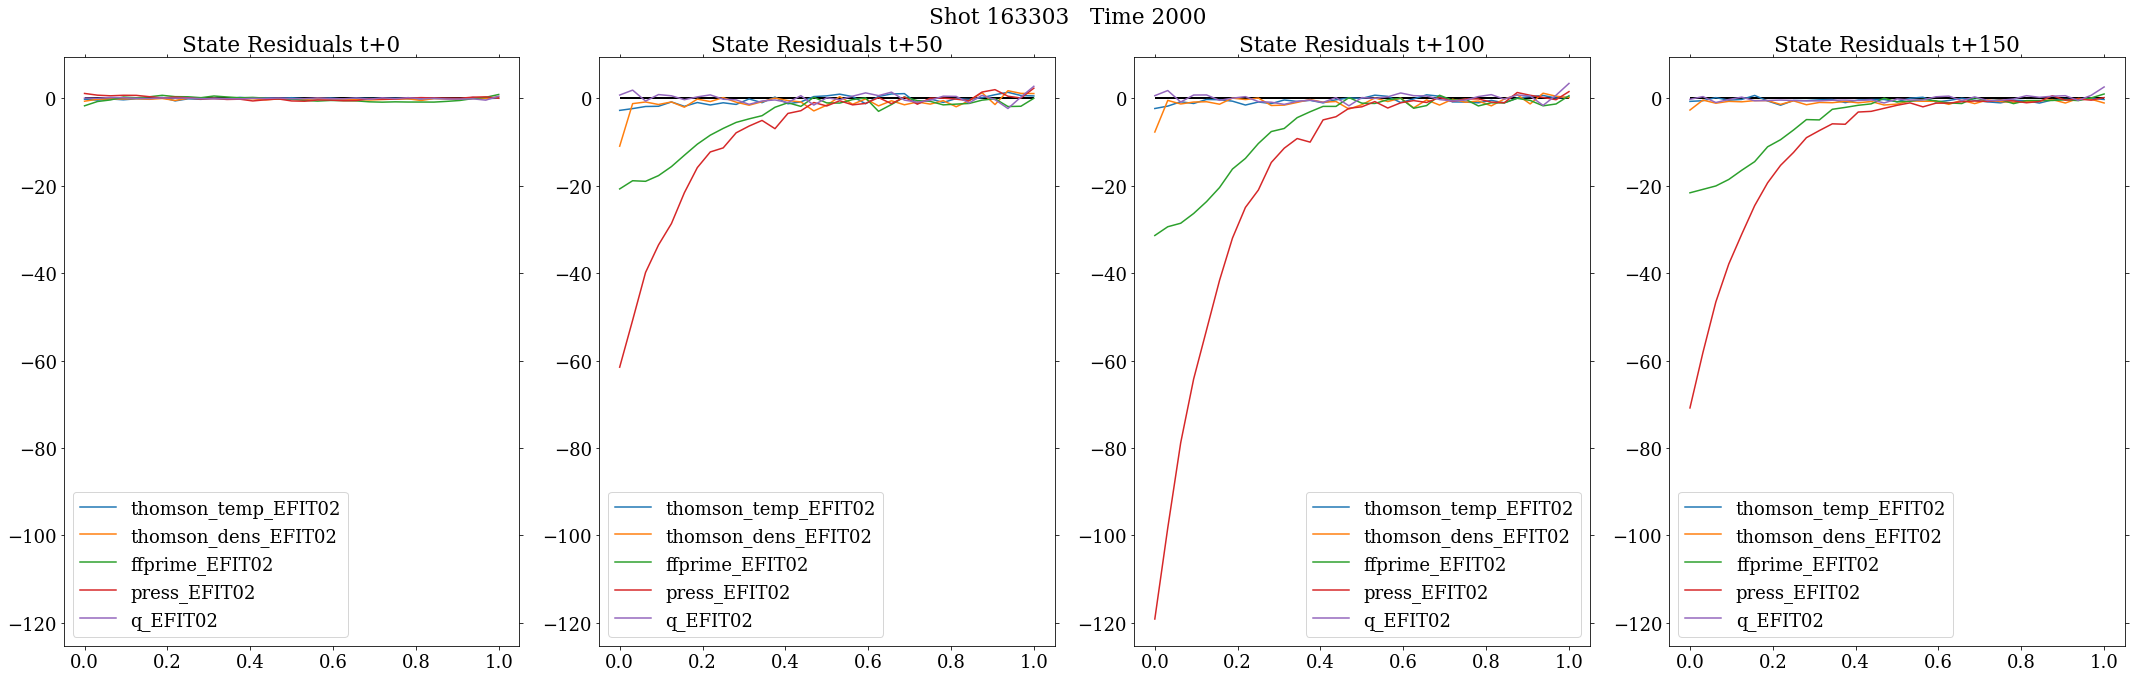

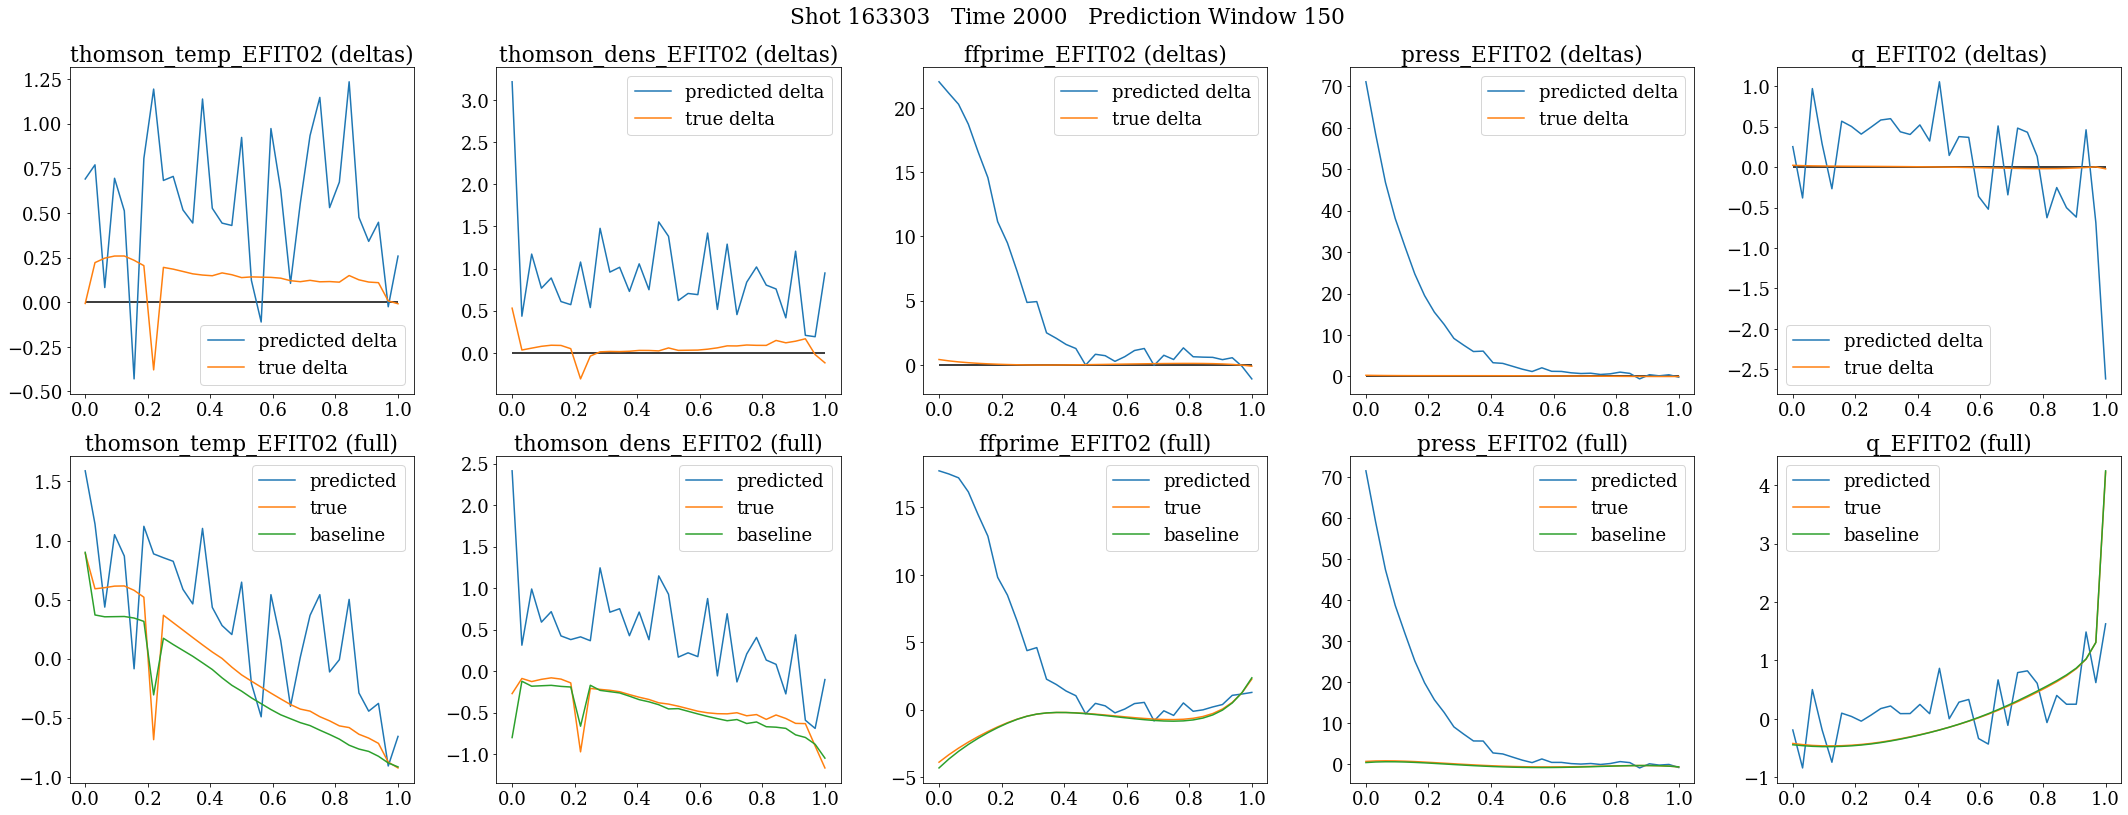

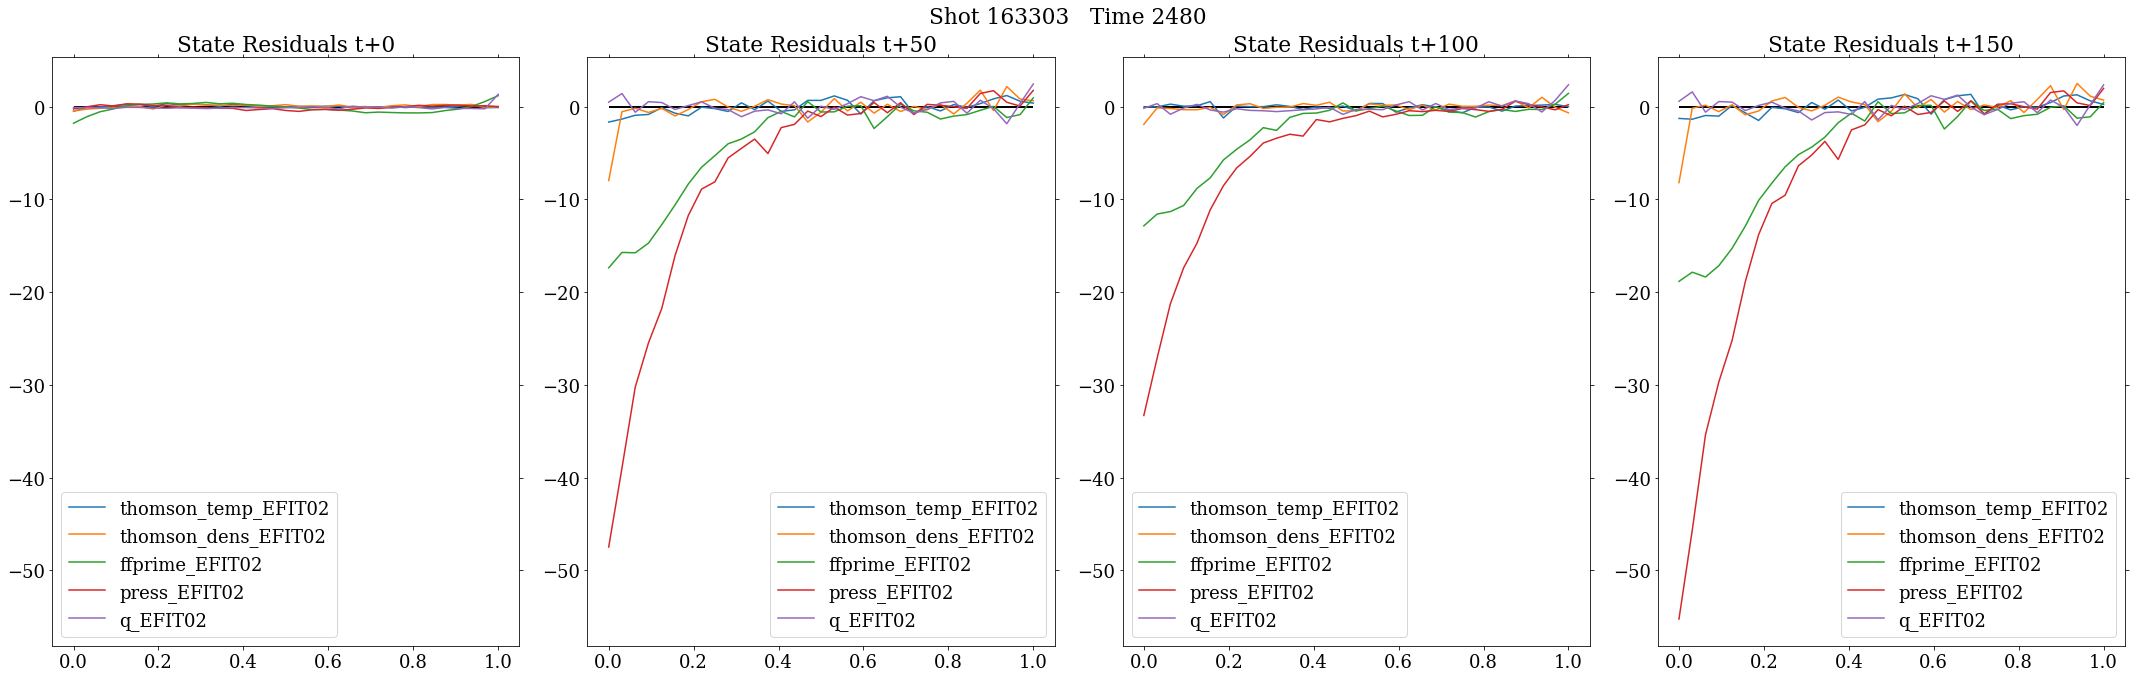

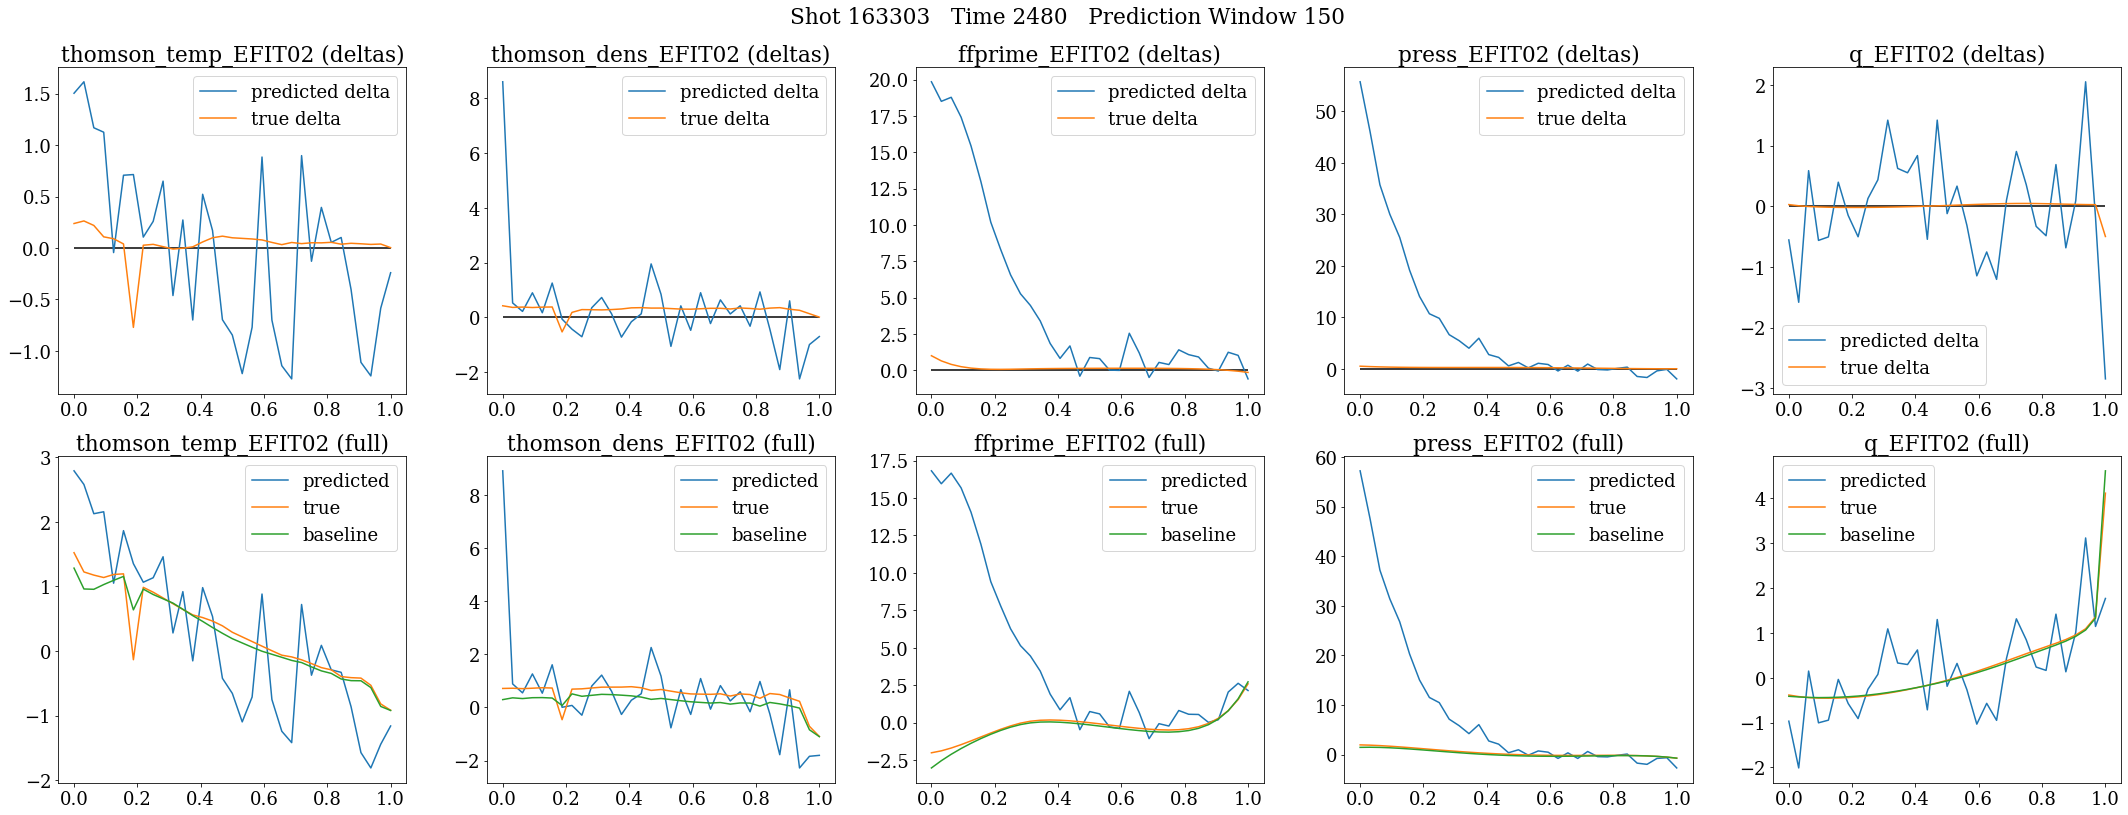

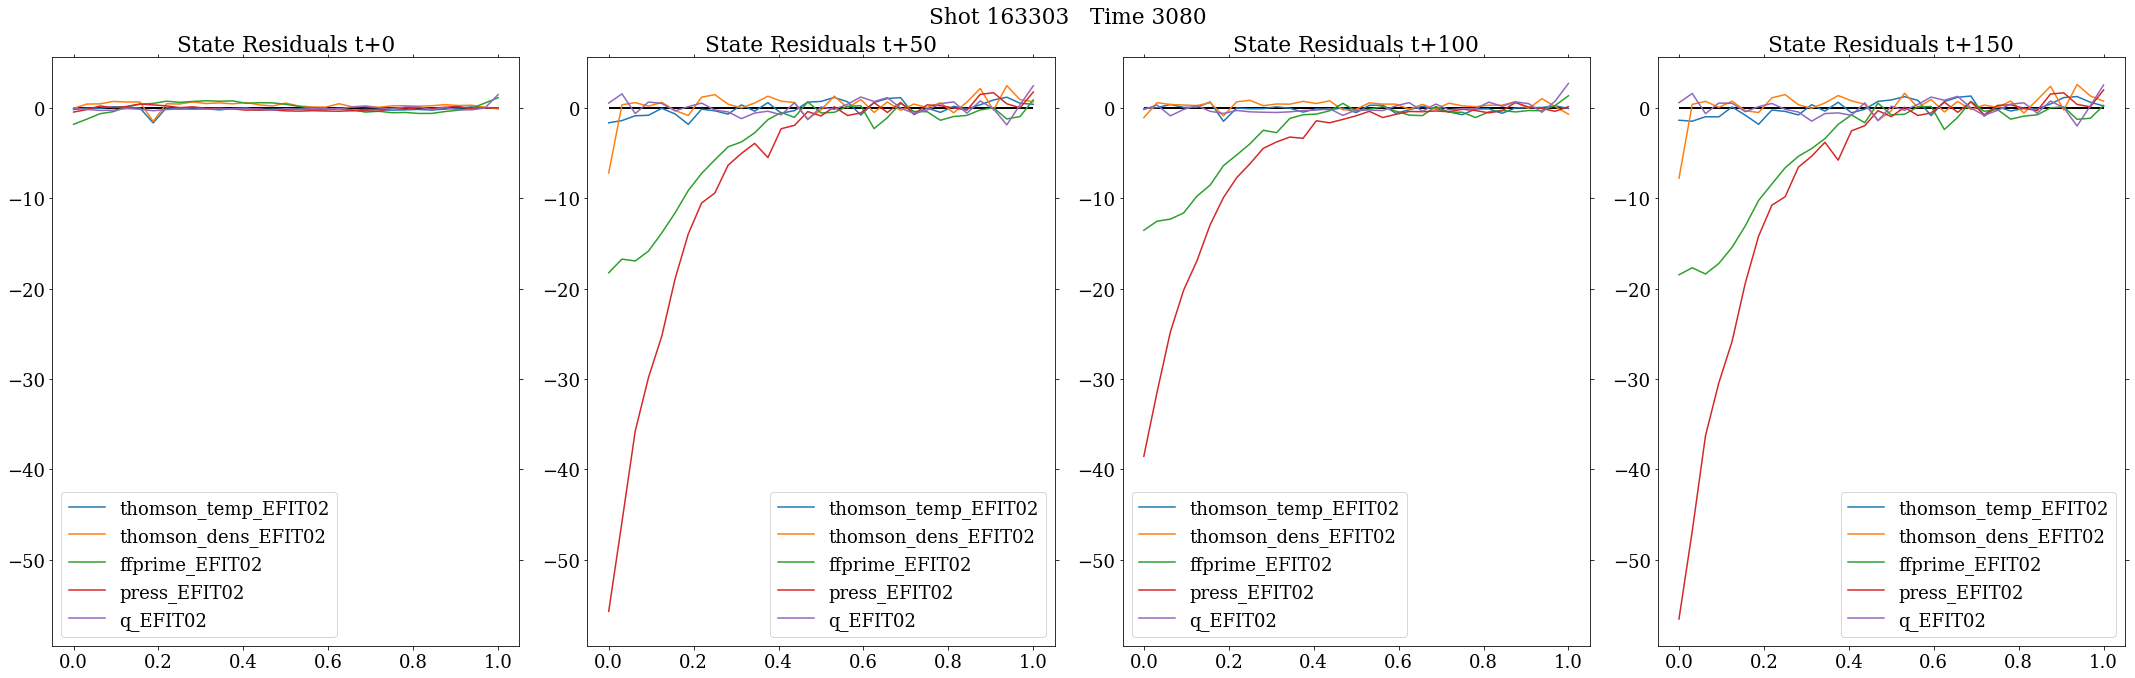

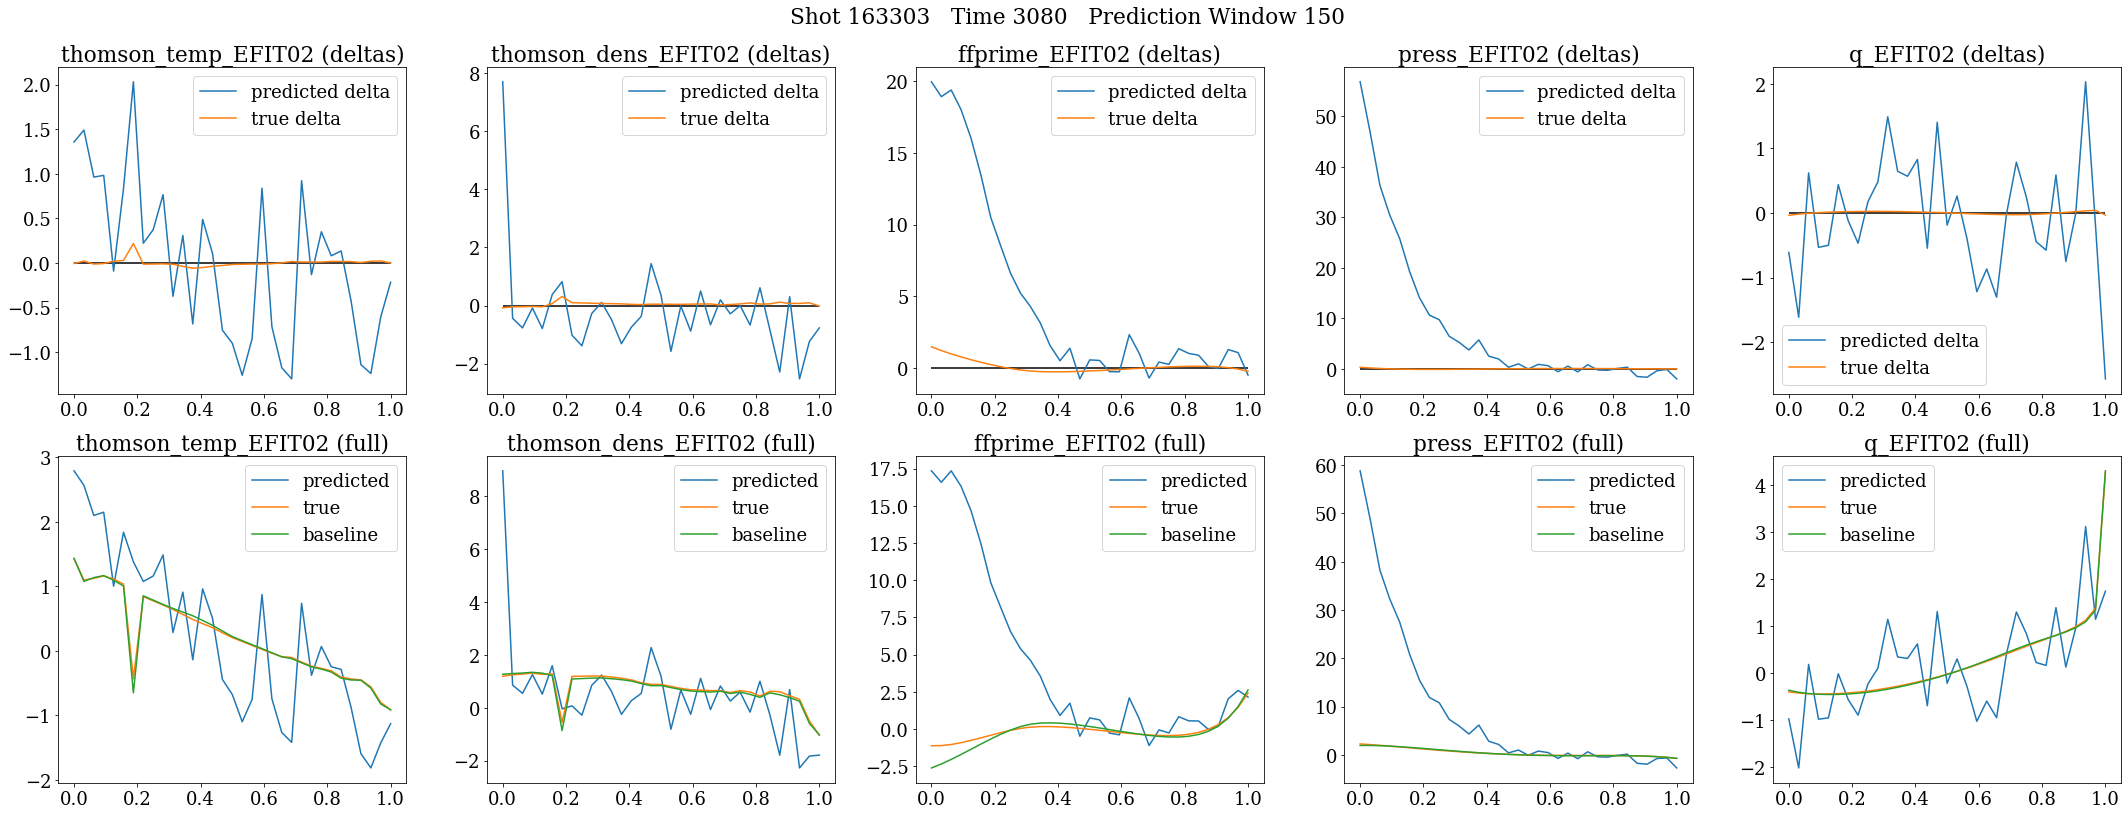

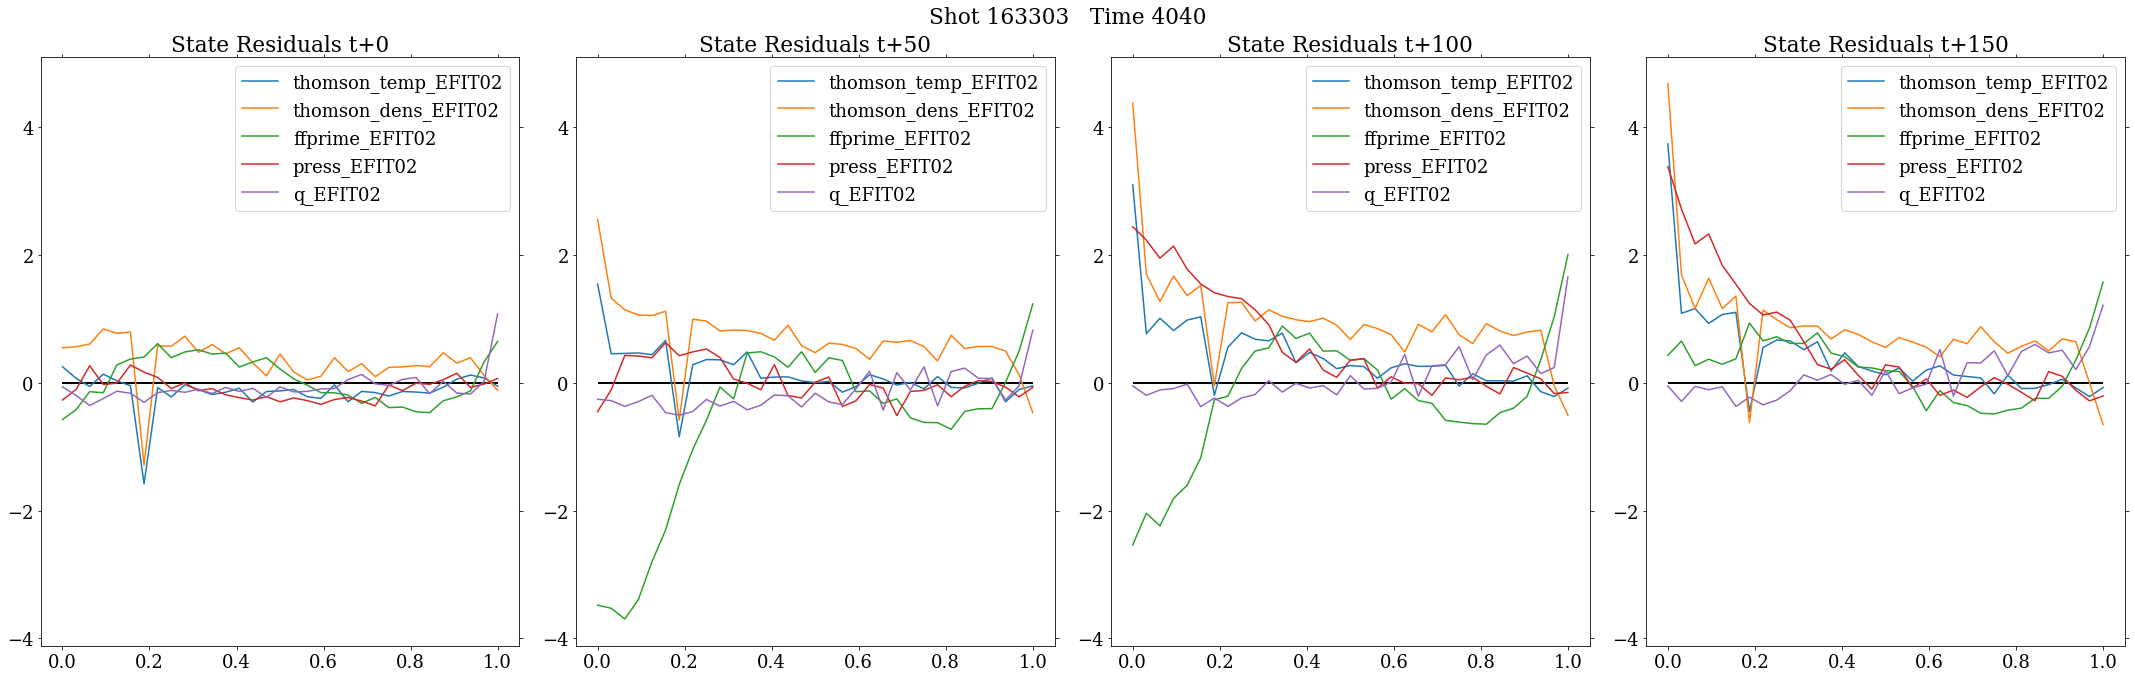

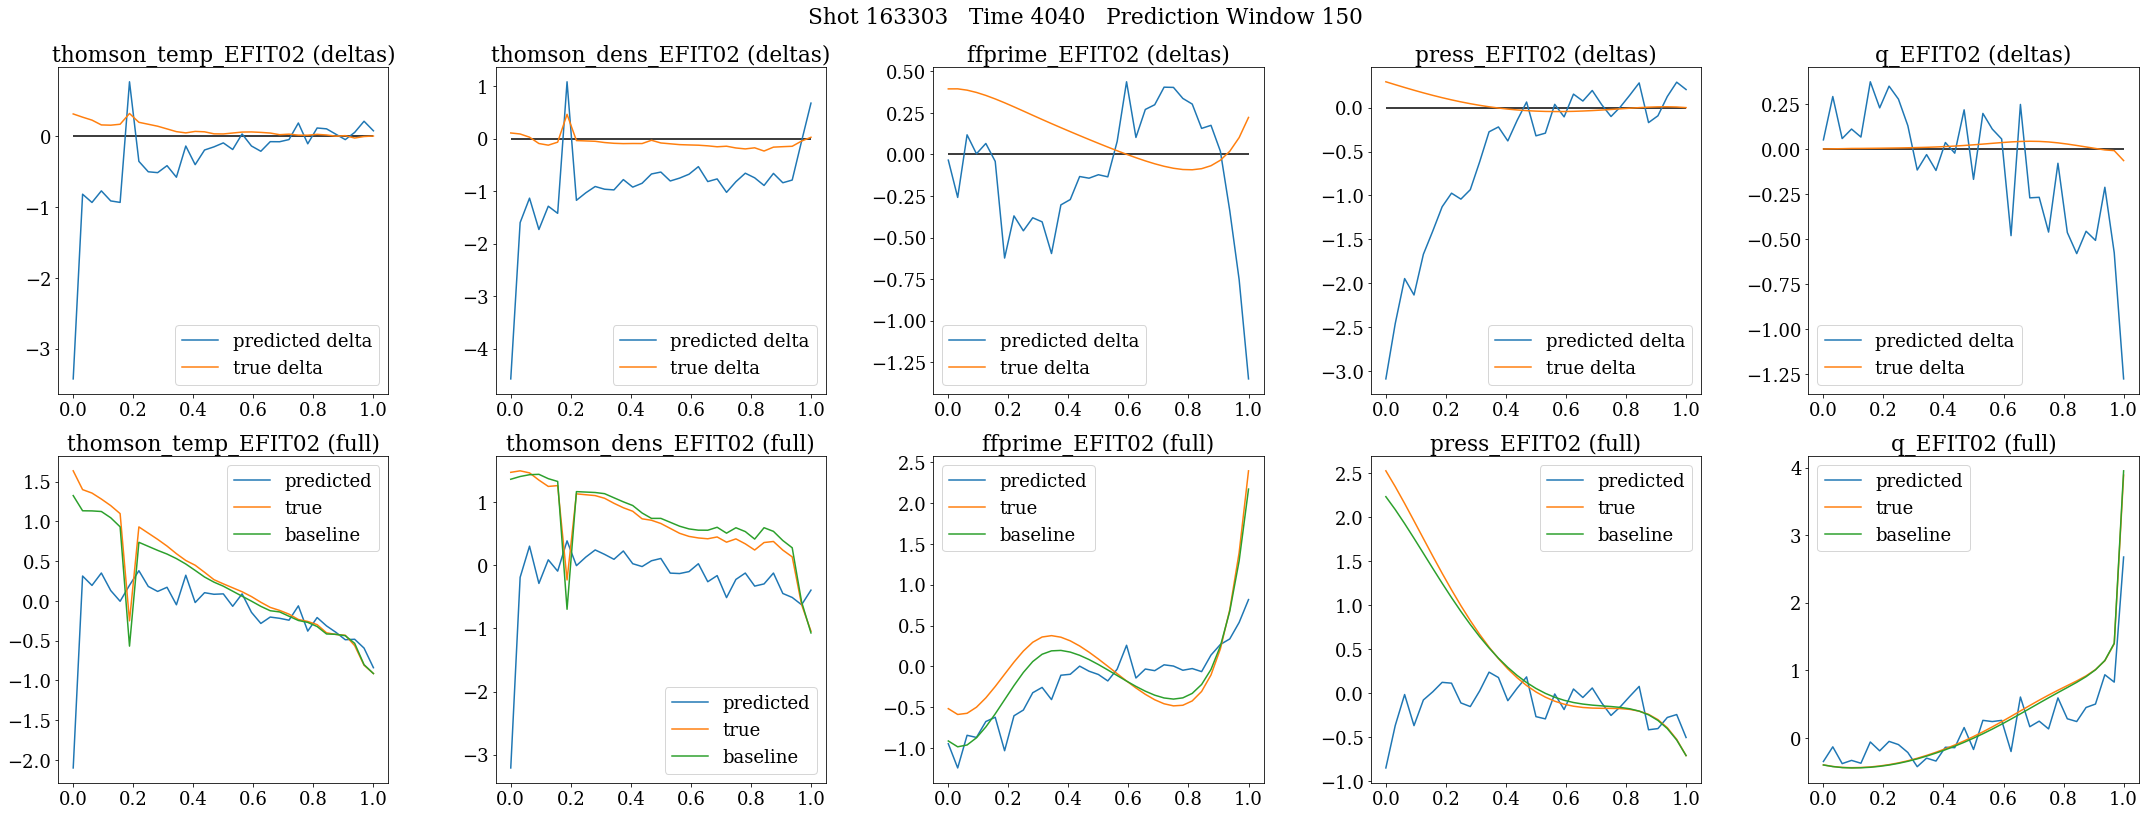

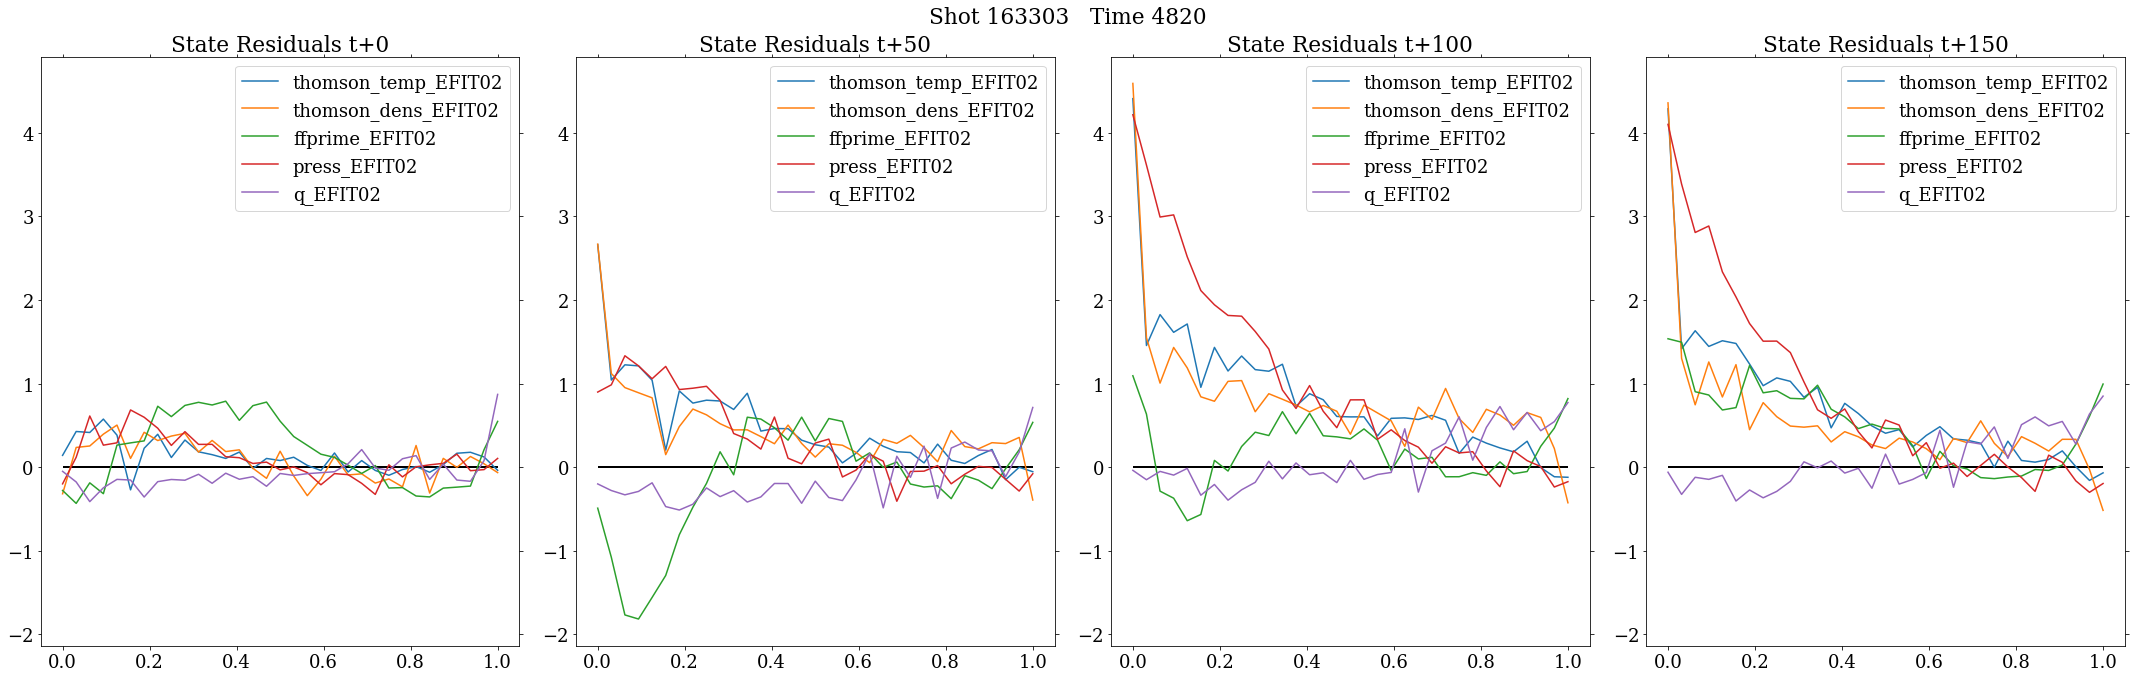

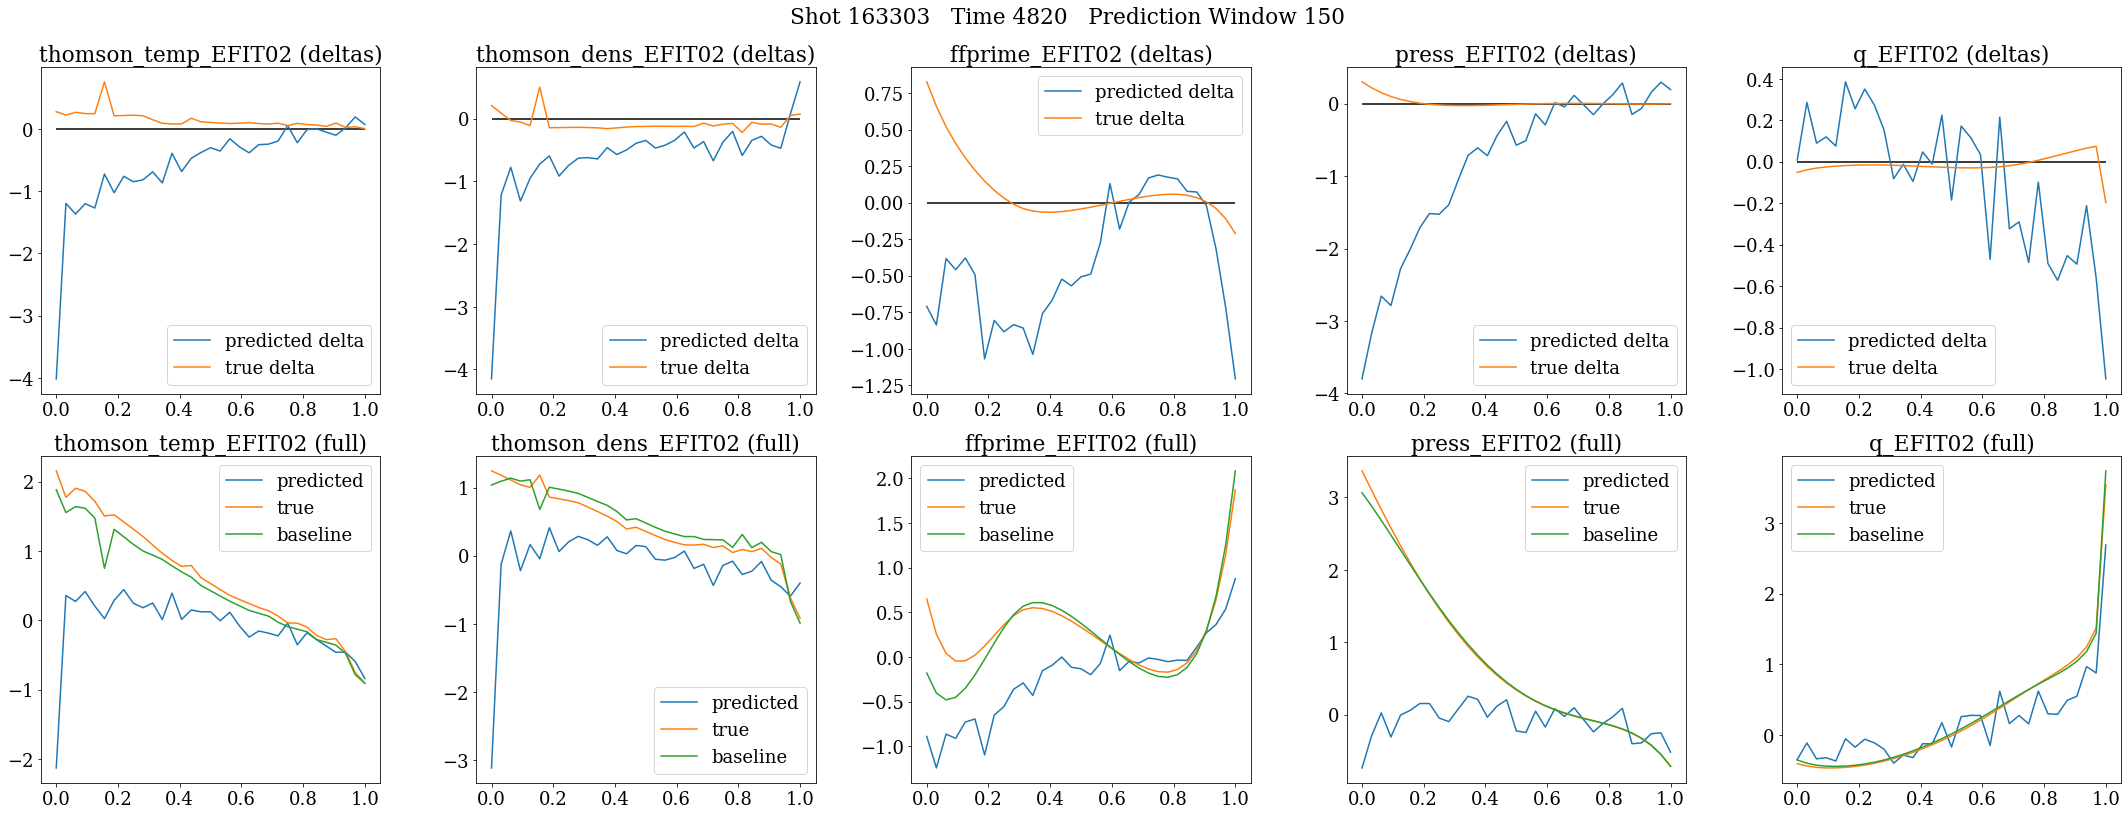

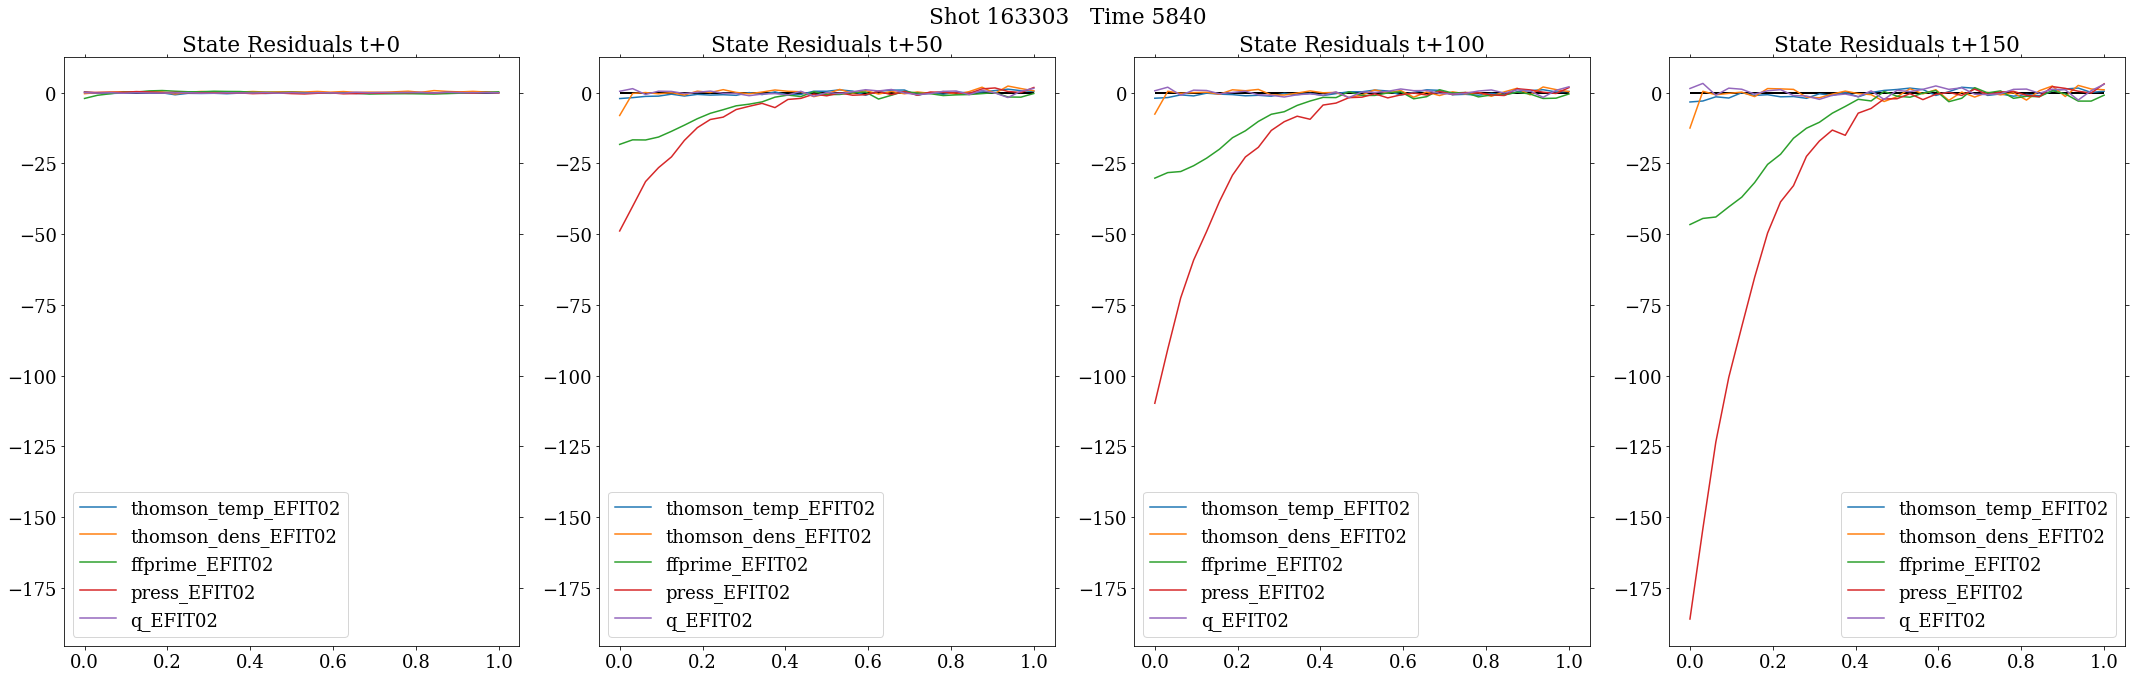

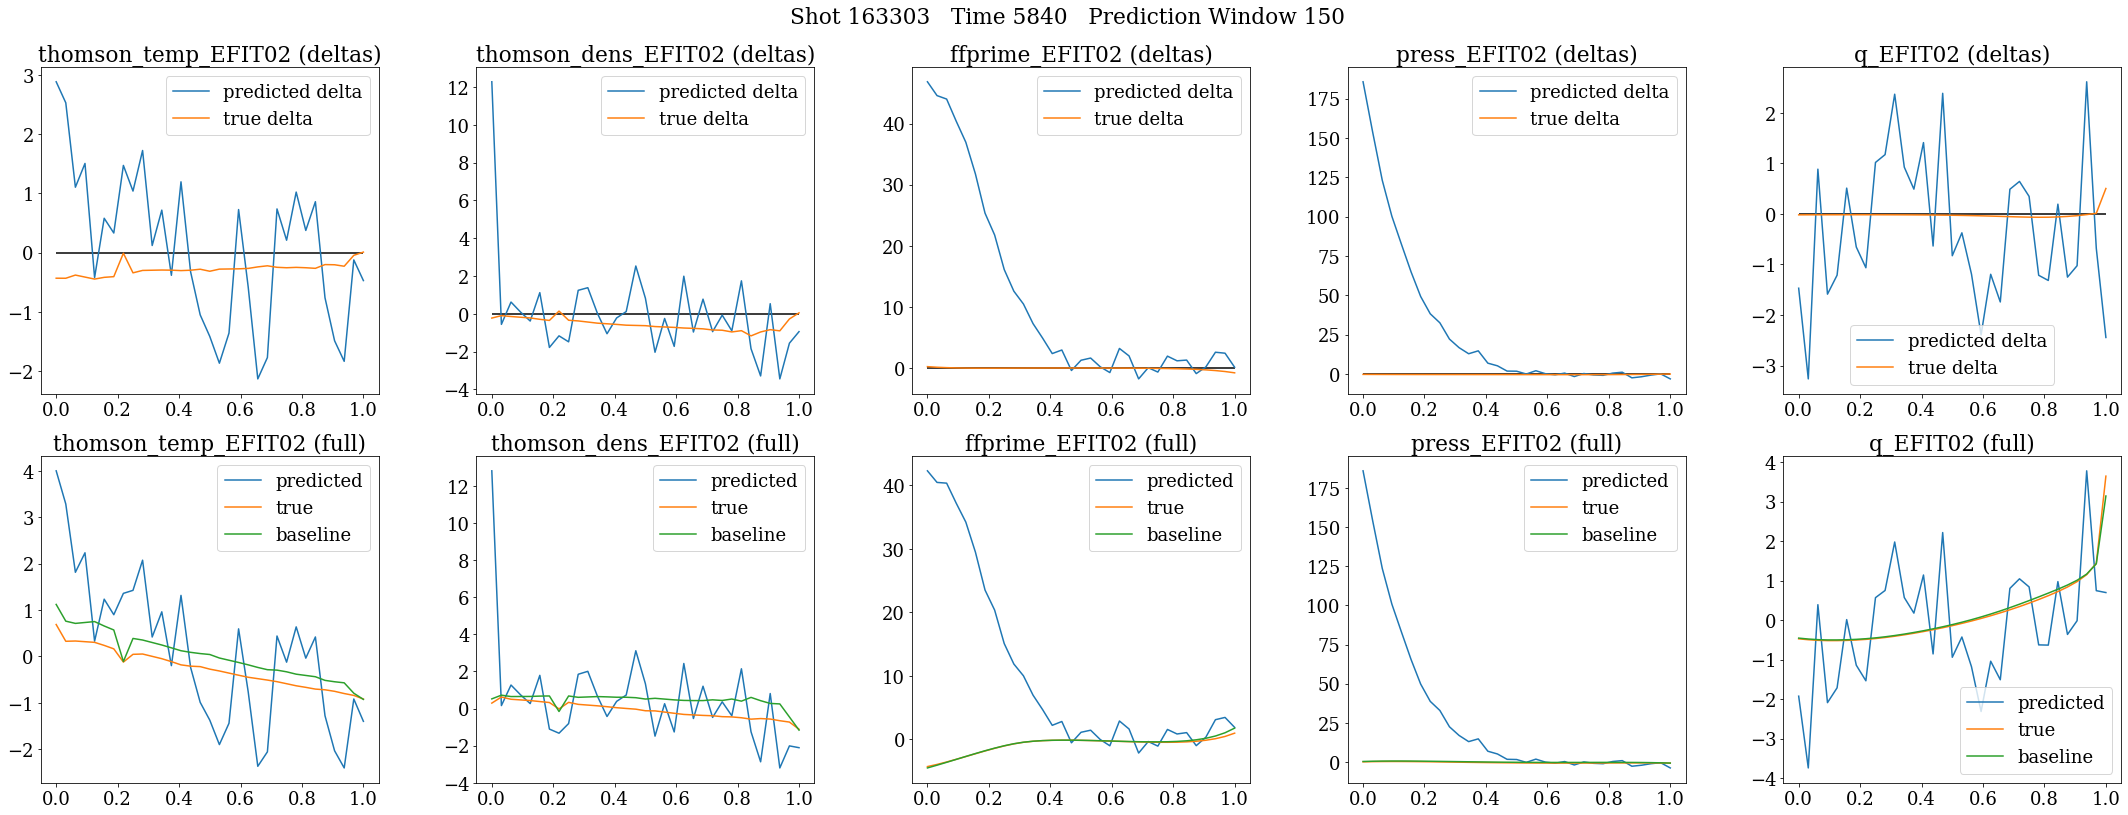

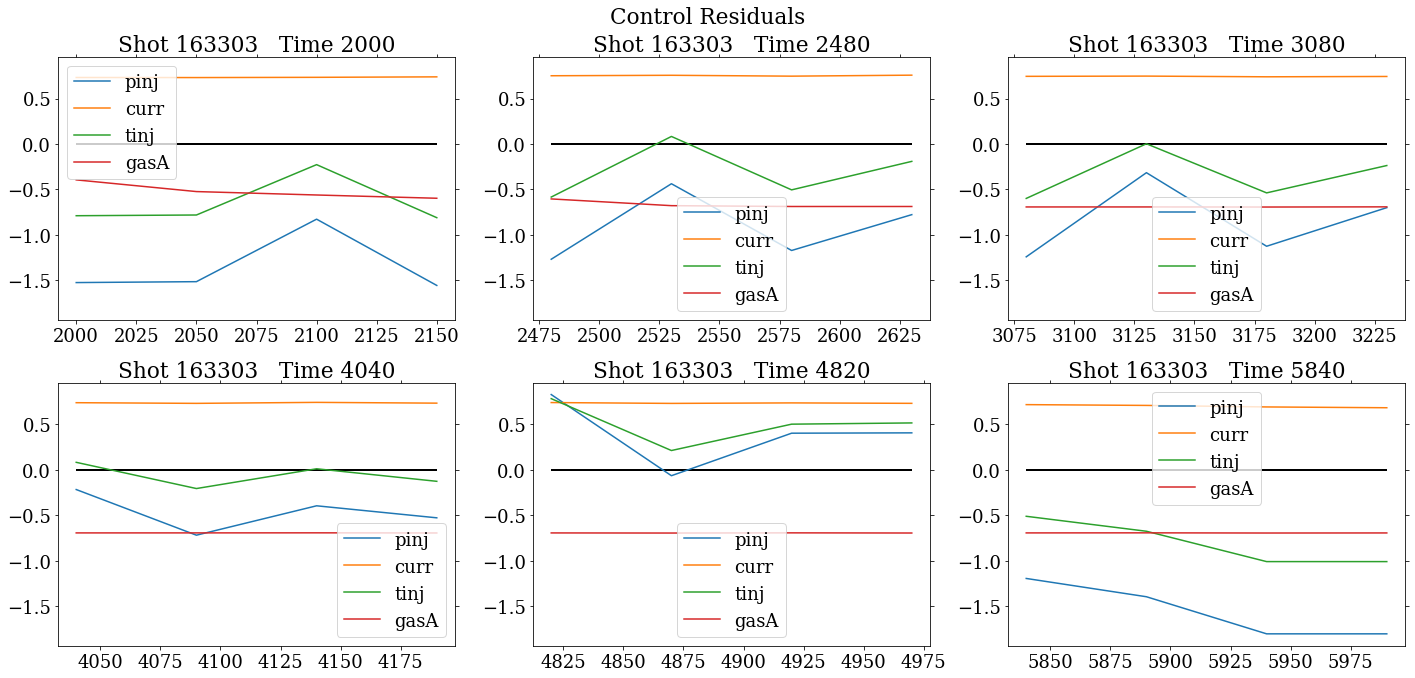

In [28]:
def get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,inputs,shot,timestep,**kwargs):

    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs['input_'+sig])
        x0['input_'+sig] = inputs['input_'+sig][:,0,:].reshape((1,1,scenario['profile_length']))
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs['input_'+sig]
    # encode control    
    T = scenario['lookback'] + scenario['lookahead'] +1
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    x = [x0]
    for i in range(scenario['lookahead']):
        x.append(A.dot(x[i]+B.dot(u[i])))
    # decode state and organize
    x_decoded = []
    for elem in x:
        x_decoded.append(state_decoder.predict(elem[np.newaxis,:]))
    state_predictions = {}
    residuals = {}
    for i, sig in enumerate(scenario['profile_names']):
        state_predictions[sig] = np.squeeze(np.array([x_decoded[j][i] for j in range(len(x_decoded))]))
        residuals[sig] = state_inputs[sig] - state_predictions[sig]
    return state_inputs, state_predictions, residuals
    
def plot_autoencoder_residuals(residuals,scenario,shot,timestep,filename=None, **kwargs):

    psi = np.linspace(0,1,scenario['profile_length'])
    nsteps = scenario['lookahead']+1

    figsize = (30,10)
    fig, ax = plt.subplots(1,nsteps, figsize=figsize,sharey=True)
    fig.suptitle('Shot ' + str(int(shot)) + '   Time ' + str(int(timestep)),y=.95)
    for j in range(nsteps):
        for i, sig in enumerate(scenario['profile_names']):
            ax[j].plot(psi,residuals[sig][j].reshape((scenario['profile_length'],)),label=sig)
            ax[j].hlines(0,0,1)
            ax[j].legend()
            ax[j].tick_params(reset=True)
            ax[j].title.set_text('State Residuals t+' + str(int(j*scenario['dt']*1000)))
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)     

    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    return fig 
    
def plot_autoencoder_predictions_timestep(state_inputs, state_predictions, scenario, shot, timestep, filename=None, **kwargs):
    

    baseline = {k:v[0].reshape((scenario['profile_length'],)) for k,v in state_inputs.items()}
    true = {k:v[-1].reshape((scenario['profile_length'],)) for k,v in state_inputs.items()}
    pred = {k:v[-1].reshape((scenario['profile_length'],)) for k,v in state_predictions.items()}

    psi = np.linspace(0,1,scenario['profile_length'])
    ncols = len(scenario['profile_names'])
    nrows = 2
    figsize = (30,12)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle('Shot ' + str(int(shot)) + '   Time ' + str(int(timestep)) + '   Prediction Window ' 
                 + str(int(scenario['lookahead']*scenario['dt']*1000)),y=.95)
    for i, sig in enumerate(scenario['profile_names']):
        
        ax[0,i].plot(psi,pred[sig]-baseline[sig],psi,true[sig]-baseline[sig])
        ax[0,i].title.set_text(sig + ' (deltas)')
        ax[0,i].hlines(0,0,1)
        ax[0,i].legend(['predicted delta','true delta'])
        
        ax[1,i].plot(psi,pred[sig],psi,true[sig],psi, baseline[sig])
        ax[1,i].title.set_text(sig + ' (full)')
        ax[1,i].legend(['predicted','true','baseline'])
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)    
    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    return fig        

def plot_autoencoder_profiles(model,scenario,generator,shots,times):
    figs = []
    html = ''
    A,B = get_AB(model)
    state_encoder, state_decoder, control_encoder, control_decoder = get_submodels(model)
    inputs, targets, actual = generator.get_data_by_shot_time(shots,times)
    for i, (shot,time) in enumerate(zip(actual['shots'],actual['times'])):
        inp = {sig:arr[np.newaxis,i] for sig, arr in inputs.items()}
        state_inputs, state_predictions, residuals = get_autoencoder_predictions(
            state_encoder,state_decoder,control_encoder,A,B,scenario,inp,shot,time)
        filename = 'residuals_shot' + str(int(shot)) + 'time' + str(int(time)) + '.png'
        fig, newhtml = plot_autoencoder_residuals(residuals,scenario,shot,time,filename)
        figs.append(fig)
        html += newhtml + '\n'
        
        filename = 'profiles_shot' + str(int(shot)) + 'time' + str(int(time)) + '.png'
        fig, newhtml = plot_autoencoder_predictions_timestep(state_inputs, state_predictions, scenario,shot,time,filename)
        figs.append(fig)
        html += newhtml + '\n'
    
    return figs, html


def plot_autoencoder_control_encoding(model,scenario,generator,shots,times,filename=None,**kwargs):

    state_encoder, state_decoder, control_encoder, control_decoder = get_submodels(model)
    inputs, targets, actual = generator.get_data_by_shot_time(shots,times)
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs['input_'+sig]
    figsize = (20,10)
    nrows = int(np.ceil(len(shots)/3))
    ncols = min(len(shots),3)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize,squeeze=False,sharey=True)
    fig.suptitle('Control Residuals',y=.95)
    
    for j, (shot,time) in enumerate(zip(shots,times)):
        inp = {sig:arr[j] for sig, arr in control_inputs.items() }
        residuals = []
        T = scenario['lookback'] + scenario['lookahead'] +1
        for i in range(T):
            temp_input = {k:v[i].reshape((1,1,1)) for k,v in inp.items()}
            encoded_control = control_encoder.predict(temp_input)
            residuals.append(np.squeeze(control_decoder.predict(encoded_control)))
        residuals = {sig:np.squeeze(inp['input_'+sig]-np.array(residuals)[:,i]) for i, sig in enumerate(scenario['actuator_names'])}

        t = np.arange(time,time+(T)*scenario['dt']*1000,scenario['dt']*1000)
        for i, sig in enumerate(scenario['actuator_names']):
            ax[np.unravel_index(j,(nrows,ncols))].plot(t,residuals[sig], label=sig)
            ax[np.unravel_index(j,(nrows,ncols))].hlines(0,min(t),max(t))
            ax[np.unravel_index(j,(nrows,ncols))].tick_params(reset=True)
            ax[np.unravel_index(j,(nrows,ncols))].legend()
            ax[np.unravel_index(j,(nrows,ncols))].title.set_text('Shot ' + str(int(shot)) + '   Time ' + str(int(time)))
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)     

    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html    
    return fig


# state_inputs, state_predictions, residuals = get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,inputs,175702,1400)
# f = plot_autoencoder_residuals(residuals,scenario,175702,1400)
# f = plot_autoencoder_predictions_timestep(state_inputs, state_predictions, scenario,175702,1400)
f = plot_autoencoder_profiles(model,scenario, generator,shots,times)
r = plot_auto_encoder_control_encoding(model,scenario,generator,shots,times)

In [154]:
state_inputs['thomson_temp_EFIT02']

array([[-0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623],
       [-0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623, -0.93005623, -0.93005623,
        -0.93005623, -0.93005623, -0.93005623],
       [-0.93005623, -0.9300

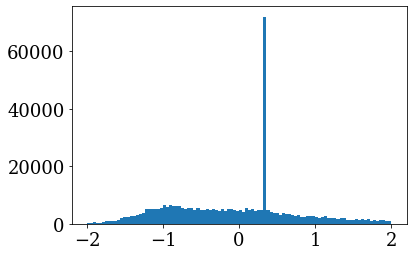

In [168]:
_ = plt.hist(traindata['ffprime_EFIT02'].flatten(),bins=100,range=(-2,2))

In [198]:
control_inputs = {}
for sig in scenario['actuator_names']:
    control_inputs['input_'+sig] = inputs['input_'+sig]
control_inputs['input_pinj'].shape

(2, 4)

In [89]:
r

{'pinj': array([[-0.27357344, -0.2689174 ,  0.13899382,  0.34612124]]),
 'curr': array([[1.30719212, 1.38421418, 1.48436317, 1.56899235]]),
 'tinj': array([[-0.01420963, -0.01236839,  0.22646378,  0.34782785]]),
 'gasA': array([[-0.67400797, -0.67017866, -0.67077143, -0.68987053]])}

In [75]:
control_encoder.predict([np.array([0]).reshape((1,1,1)),
                        np.array([0]).reshape(1,1,1),
                        np.array([0]).reshape((1,1,1)),
                        np.array([0]).reshape((1,1,1))])

array([[0.        , 0.20368785, 0.        , 0.15114146, 0.12249056]],
      dtype=float32)

In [188]:
'input_pinj'.split('_')

['input', 'pinj']

In [87]:
from keras import backend as K
x = K.variable(np.array([[1,1,1,1]]))

K.eval(control_encoder.layers[9](x))

array([[0.        , 0.26055753, 0.        , 0.        ]], dtype=float32)

In [83]:
control_encoder.layers[5].get_weights()

[array([[-1.2700672e+00,  1.2836251e-01,  1.1880429e-01, -1.7476048e-01],
        [-8.1750959e-01,  1.0627987e-03, -3.4490132e-01, -1.6073769e+00],
        [-5.9069467e-01,  2.9652322e-02, -8.2191342e-01, -1.3312887e-01],
        [-1.2067087e+00, -7.1192133e-01, -5.9554058e-01,  1.0705830e+00]],
       dtype=float32),
 array([ 0.17181875, -0.2534322 ,  0.08268268,  0.15101635], dtype=float32)]

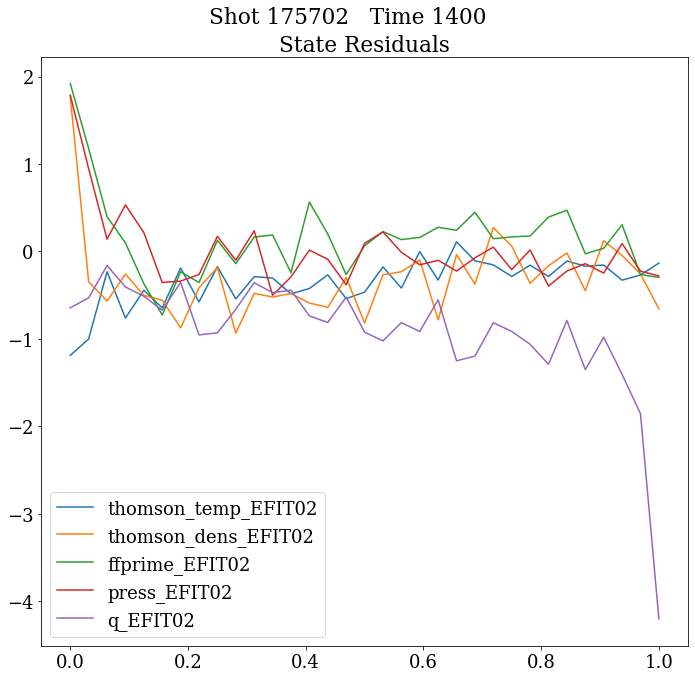

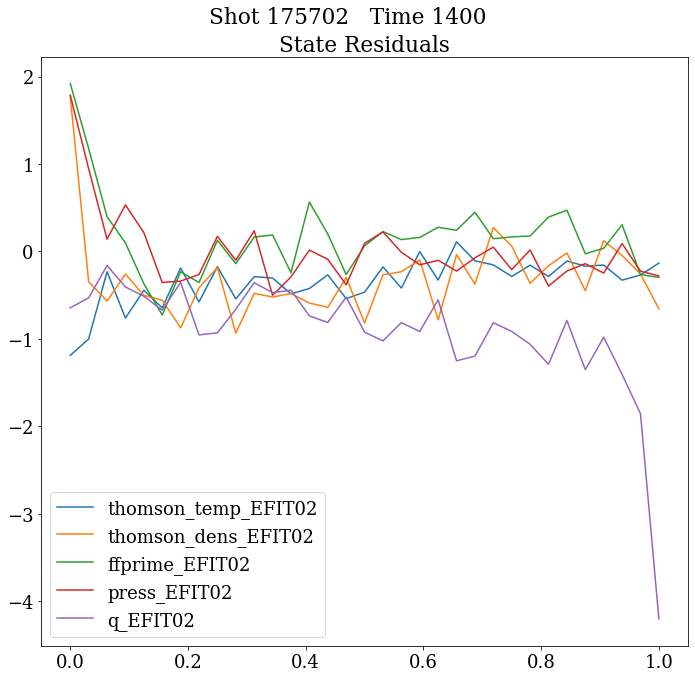

In [119]:
def plot_state_encoding(encoder,decoder,scenario,inputs,shot,timestep,filename=None,**kwargs):
    
    encoded_state = encoder.predict(inputs)
    decoded_state = decoder.predict(encoded_state)
    psi = np.linspace(0,1,scenario['profile_length'])

    figsize = (10,10)
    fig, ax = plt.subplots(1,1, figsize=figsize)
    fig.suptitle('Shot ' + str(int(shot)) + '   Time ' + str(int(timestep)),y=.95)

    for i, sig in enumerate(scenario['profile_names']):
        ax.plot(psi,inputs['input_'+sig].reshape((scenario['profile_length'],))-decoded_state[i].reshape((scenario['profile_length'],)),label=sig)
        ax.legend()
        ax.title.set_text('State Residuals')
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)     
    
    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    return fig

plot_state_encoding(state_encoder,state_decoder,scenario,state_inputs1,175702,1400)

In [8]:
os.getcwd()



'/home/wconlin/run_results_11_19'

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from keras.models import Model
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
import keras
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
import copy
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from tqdm import tqdm
from helpers.results_processing import write_autoencoder_results, write_conv_results

os.chdir(os.path.expanduser('~/run_results_11_19'))
os.getcwd()
dir_path = os.getcwd()


def clean_dir(dir_path):
    all_files = os.listdir(os.path.abspath(dir_path))
    model_files = [f for f in all_files if f.endswith('.h5')]
    scenario_files = [f for f in all_files if f.endswith('params.pkl')]
    drivers = [f for f in all_files if f.endswith('.sh')]
    for f in drivers:
        os.remove(f)
    for f in model_files:
        scenario_path = f[:-3] + '_params.pkl'
        if not os.path.exists(scenario_path):
            print('No scenario found for {}'.format(f))
            os.remove(f)
    for f in scenario_files:
        model_path = f[:-11] + '.h5'
        if not os.path.exists(model_path):
            print('No model found for {}'.format(f))
            os.remove(f)

def process_results_folder(dir_path):
    clean_dir(dir_path)
    all_files = os.listdir(os.path.abspath(dir_path))
    model_files = [f for f in all_files if f.endswith('.h5')]
    drivers = [f for f in all_files if f.endswith('.sh')]
    for f in tqdm(model_files):
        model_path = os.path.abspath(dir_path) +'/'+ f
        model = keras.models.load_model(model_path, compile=False)
        scenario_path = model_path[:-3] + '_params.pkl'
        try:
            with open(scenario_path, 'rb') as fo:
                scenario = pickle.load(fo, encoding='latin1')
#             print('Loaded model and scenario: {}'.format(str(f)))
        except:
            print('No scenario file found for model {}'.format(str(f)))
            os.remove(f)

        if 'autoencoder' in scenario['runname']:
            try:
                write_autoencoder_results(model, scenario)
            except KeyError as key:
                print('missing key {} for run {}'.format(key.args[0],str(f)))
                
        else:
            try:
                write_conv_results(model,scenario)
            except KeyError as key:
                print('missing key {} for run {}'.format(key.args[0],str(f)))

In [13]:
x_weight = K.variable(1)
u_weight = K.variable(1)
linear_system_weight = K.variable(1)

cb = DynamicWeighting(x_weight,u_weight,linear_system_weight,'x_mse','u_mse','linear_system_mse','epoch')
cb.on_epoch_end(1,{'x_mse':5,'u_mse':3,'linear_system_mse':1})
K.eval(u_weight)

0.33333334

In [46]:
import keras
from keras.callbacks import Callback
from keras.callbacks import TensorBoard
import keras.backend as K
import numpy as np

class DynamicWeighting(Callback):
    """Callback that updates weights of different losses to maintain balance"""
    
    def __init__(self,weights,metrics,mode='epoch'):
        for weight in weights:
            if type(weight) is not type(K.variable(1)):
                raise TypeError("All weights for dynamic weighting must be keras tensors. Got {}".format(type(weight)))
        assert len(weights) == len(metrics), "Each weight must have a corresponding metric"
        self.weights = weights
        self.metrics = metrics
        self.mode = mode
        self.total_weight = np.sum([K.eval(weight) for weight in self.weights])
        
    def on_batch_end(self,batch,logs={}):
        if self.mode == 'batch':
            losses = [logs.get(metric,0) for metric in self.metrics]
            total_loss = np.sum(losses)
            if total_loss >0:
                for weight, loss in zip(weights,losses):
                    K.set_value(weight, loss/total_loss)
        else:
            pass
        
    def on_epoch_end(self,epoch,logs):
        if self.mode == 'epoch':
            losses = [logs.get(metric,0) for metric in self.metrics]
            total_loss = np.sum(losses)
            if total_loss >0:
                for weight, loss in zip(weights,losses):
                    K.set_value(weight, self.total_weight*loss/total_loss)
        else:
            pass          

In [43]:
a = K.variable(1)


In [45]:
type(K.variable(5)) is type(a)

True

In [41]:
type(K.variable(5))

tensorflow.python.ops.variables.Variable